# Import modules

In [1]:
# import modules and functions

import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.preprocessing import binarize
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib.pyplot import cm
np.random.seed(7)

/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Functions

In [2]:
def run_clf(clf_name, X_train, y_train, X_test, costSensitive): # input should only be which classifier we want and data 
    '''This function takes in training/testing data and a classifier name request, performs a cross-validated
    hyperparameter grid search and returns a prediction vector for testing data. It will be easy to add cost
    sensitivity to SVM's and any new classifiers at a later time.'''
    if clf_name == 'rbf':
        if costSensitive:
            param_grid = [
            {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': [10,1,0.1,0.01,0.001, 0.0001, 0.00001]}
            ]
            clf_gs = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
            clf_gs.fit(X_train, y_train)
            clf_rbf = SVC(class_weight={0:clf_gs.best_params_.get('C'),1:1.5*clf_gs.best_params_.get('C')},
                          gamma=clf_gs.best_params_.get('gamma'), kernel = 'rbf', probability=True)
            clf_rbf.fit(X_train, y_train)
            probs_clf = clf_rbf.predict_proba(X_test)[:, 1]
        else:
            param_grid = [
            {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': [10,1,0.1,0.01,0.001, 0.0001, 0.00001]}
            ]
            clf_gs = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
            clf_gs.fit(X_train, y_train)
            clf_rbf = SVC(C=clf_gs.best_params_.get('C'), gamma=clf_gs.best_params_.get('gamma'), kernel = 'rbf', probability=True) #class_weight='balanced'
            clf_rbf.fit(X_train, y_train)
            probs_clf = clf_rbf.predict_proba(X_test)[:, 1]
        training_predictions = clf_rbf.predict_proba(X_train)[:, 1]
        params = tuple((clf_gs.best_params_.get('C'), clf_gs.best_params_.get('gamma')))
    if clf_name == 'lin':
        if costSensitive:
            param_grid = [
            {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
            ]
            clf_gs = GridSearchCV(LinearSVC(), param_grid, cv=5)
            clf_gs.fit(X_train, y_train)
            clf_lin = LinearSVC(class_weight={0:clf_gs.best_params_.get('C'),1:1.5*clf_gs.best_params_.get('C')})
            clf_lin.fit(X_train, y_train)
            probs_clf = clf_lin.decision_function(X_test)
        else:
            param_grid = [
            {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
            ]
            clf_gs = GridSearchCV(LinearSVC(), param_grid, cv=5)
            clf_gs.fit(X_train, y_train)
            clf_lin = LinearSVC(C=clf_gs.best_params_.get('C'))
            clf_lin.fit(X_train, y_train)
            probs_clf = clf_lin.decision_function(X_test)
        training_predictions = clf_lin.decision_function(X_train)
        params = clf_gs.best_params_.get('C')
    if clf_name == 'poly':
        if costSensitive:
            param_grid = [
            {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': [10,1,0.1,0.01,0.001, 0.0001, 0.00001]},
            ]
            clf_gs = GridSearchCV(SVC(kernel='poly'), param_grid, cv=5)
            clf_gs.fit(X_train, y_train)
            clf_poly = SVC(class_weight={0:clf_gs.best_params_.get('C'),1:1.5*clf_gs.best_params_.get('C')},
                           gamma=clf_gs.best_params_.get('gamma'), kernel = 'poly', probability=True)
            clf_poly.fit(X_train, y_train)
            probs_clf = clf_poly.predict_proba(X_test)[:, 1]
        else:
            param_grid = [
            {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': [10,1,0.1,0.01,0.001, 0.0001, 0.00001]},
            ]
            clf_gs = GridSearchCV(SVC(kernel='poly'), param_grid, cv=5)
            clf_gs.fit(X_train, y_train)
            clf_poly = SVC(C=clf_gs.best_params_.get('C'), gamma=clf_gs.best_params_.get('gamma'), kernel = 'poly', probability=True)
            clf_poly.fit(X_train, y_train)
            probs_clf = clf_poly.predict_proba(X_test)[:, 1]
        params = tuple((clf_gs.best_params_.get('C'), clf_gs.best_params_.get('gamma')))
        training_predictions = clf_poly.predict_proba(X_train)[:, 1]
    if clf_name == 'rf':
        rfc = RandomForestClassifier(n_jobs = -1, max_features = 'sqrt', n_estimators = 32, oob_score = True) 
        param_grid = { 
            'n_estimators': [50, 100, 200, 500],
            'max_features': ['sqrt', 'log2']
        }
        clf_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv = 5)
        clf_rfc.fit(X_train, y_train)
        clf_rf_1 = RandomForestClassifier(n_jobs = -1, n_estimators=clf_rfc.best_params_.get('n_estimators'), max_features=clf_rfc.best_params_.get('max_features'), oob_score = True)
        clf_rf_1.fit(X_train, y_train)
        probs_clf = clf_rf_1.predict_proba(X_test)[:, 1]
        training_predictions = clf_rf_1.predict_proba(X_train)[:, 1]
        #params = tuple((clf_rfc.best_params_.get('n_estimators'), clf_rfc.best_params_.get('max_features')))
        params = clf_rf_1.feature_importances_
    if clf_name == 'log':
        if costSensitive:
            param_grid = [
                {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
            ]
            clf_gs = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
            clf_gs.fit(X_train, y_train)
            clf_log = LogisticRegression(class_weight={0:clf_gs.best_params_.get('C'),1:1.5*clf_gs.best_params_.get('C')})
            clf_log.fit(X_train, y_train)
            probs_clf = clf_log.predict_proba(X_test)[: ,1]
        else:
            param_grid = [
                {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
            ]
            clf_gs = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
            clf_gs.fit(X_train, y_train)
            clf_log = LogisticRegression(C = clf_gs.best_params_.get('C'))
            clf_log.fit(X_train, y_train)
            probs_clf = clf_log.predict_proba(X_test)[: ,1]
        training_predictions = clf_log.predict_proba(X_train)[:, 1]
        params = clf_gs.best_params_.get('C')
        
    return(probs_clf, params, training_predictions) # returns a set of predicted probabilities/response values from the chosen classifier

def generatePlotTitle(clf, costSensitive):
    '''This function generates plot titles based on a given classifier. Rather annoying to update manually.'''
    if clf == 'lin':
        if costSensitive == False:
            title = 'SVM with Linear Kernel - Not Cost Sensitive'
        else:
            title = 'SVM with Linear Kernel - Cost Sensitive'
    if clf == 'rbf':
        if costSensitive == False:
            title = 'SVM with RBF Kernel - Not Cost Sensitive'
        else:
            title = 'SVM with RBF Kernel - Cost Sensitive'
    if clf == 'poly':
        if costSensitive == False:
            title = 'SVM with Polynomial Kernel - Not Cost Sensitive'
        else:
            title = 'SVM with Polynomial Kernel - Cost Sensitive'
    if clf == 'rf':
        title = 'Random Forest'
    if clf == 'log':
        if costSensitive:
            title = 'Logistic Regression - Cost Sensitive'
        else:
            title = 'Logistic Regression - Not Cost Sensitive'
    return(title) # returns plot title

def generatePlot(requested_feature_set, x, y):
    plt.scatter(num_c, varianceExplained)
    if requested_feature_set == 'static':
        plt.axis([0, static.shape[1], 0, 1])
    if requested_feature_set == 'dynamic':
        plt.axis([0, dynamic.shape[1], 0, 1])
    if requested_feature_set == 'temporal':
        plt.axis([0, temporal.shape[1], 0, 1])
    plt.show()
    
def LR(X_train, y_train, X_test):
    param_grid = [
        {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    ]
    clf_gs = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf_gs.fit(X_train, y_train)
    clf_log = LogisticRegression(C = clf_gs.best_params_.get('C'), penalty = 'l2')
    clf_log.fit(X_train, y_train)
    probs_clf = clf_log.predict_proba(X_test)[: ,1]
    coefs = clf_log.coef_
    params = clf_gs.best_params_.get('C')
    return(probs_clf, coefs, params)

In [3]:
risk_factors = [
    'first_admit_age',
    '51222',
    '113',
    '618',
    'SURG',
    'antib',
    'high_antib'
]

In [302]:
dynamic_data = pd.read_csv('./preprocessor/output_dynamics_MRSA_new.csv', header = 0)
static_data = pd.read_csv('./generate_features/static.csv', header = 0)
static_names = static_data.drop(['hadm_id', 'label'], axis = 1).columns.values
dynamic_names = []

for i in range(5):#range(int(dynamic.shape[1]/80)):
    [dynamic_names.append(str(z)) for z in dynamic_data.columns.values[3:]]

dynamic_set_1 = ['51221', '51222','51248', '51249', '51250','51265','51277','51279','51301','50868','50882','50893','50902','50912','50931','50960','50970','50971','50983','51006']
dynamic_set_2 = ['high_antib', 'antib', 'h2', 'ppi']
dynamic_set_3 = ['CMED','CSURG','DENT','ENT','GU','GYN','MED','NB','NBB','NMED','NSURG','OBS','ORTHO','OMED','PSURG','PSYCH','SURG','TRAUM','TSURG','VSURG']
dynamic_set_4 = ['51','52','113','184','211','454','455','456','618','646','678','679','723','5813','5815','5817','5819','5820','8368','8441','8547','8549','8551','8553','8554','220045','220046','220047','220050','220051','220052','220056','220058','220074','220179','220180','220181','220210','220277','220739','223751','223752','223761','223769','223770','223900','223901','224161','224162']
dynamic_set_5 = ['YEAST','GRAM NEGATIVE ROD(S)','PSEUDOMONAS AERUGINOSA','KLEBSIELLA PNEUMONIAE','ENTEROCOCCUS SP.','ESCHERICHIA COLI','PROTEUS MIRABILIS','ENTEROBACTER CLOACAE','KLEBSIELLA OXYTOCA','ACINETOBACTER BAUMANNII','SERRATIA MARCESCENS','ENTEROBACTER AEROGENES']
dynamic_set_6 = ['los']
name_df = pd.DataFrame(dynamic_names, columns = ['feature'])
static_dynamic_names = list(static_names) + list(dynamic_names)
sd_name_df = pd.DataFrame(static_dynamic_names, columns = ['feature'])

In [303]:
dynamic_names

['50868',
 '50882',
 '50893',
 '50902',
 '50912',
 '50931',
 '50960',
 '50970',
 '50971',
 '50983',
 '51006',
 '51221',
 '51222',
 '51248',
 '51249',
 '51250',
 '51265',
 '51277',
 '51279',
 '51301',
 '51',
 '52',
 '184',
 '211',
 '454',
 '455',
 '456',
 '618',
 '646',
 '678',
 '723',
 '5813',
 '5815',
 '5817',
 '5819',
 '5820',
 '8368',
 '8441',
 '8547',
 '8549',
 '8551',
 '8553',
 '8554',
 '113',
 'NSURG',
 'TSURG',
 'OBS',
 'MED',
 'GU',
 'CMED',
 'DENT',
 'NB',
 'GYN',
 'TRAUM',
 'ENT',
 'ORTHO',
 'OMED',
 'PSURG',
 'NBB',
 'SURG',
 'NMED',
 'CSURG',
 'VSURG',
 'PSYCH',
 'high_antib',
 'antib',
 'h2',
 'ppi',
 'YEAST',
 'GRAM NEGATIVE ROD(S)',
 'PSEUDOMONAS AERUGINOSA',
 'KLEBSIELLA PNEUMONIAE',
 'ENTEROCOCCUS SP.',
 'ESCHERICHIA COLI',
 'PROTEUS MIRABILIS',
 'ENTEROBACTER CLOACAE',
 'KLEBSIELLA OXYTOCA',
 'ACINETOBACTER BAUMANNII',
 'SERRATIA MARCESCENS',
 'ENTEROBACTER AEROGENES',
 '50868',
 '50882',
 '50893',
 '50902',
 '50912',
 '50931',
 '50960',
 '50970',
 '50971',
 '50983',


In [201]:
dynamic = pd.read_csv('~/Dropbox/WPI-InfectionPrediction-Tom/MRSA/Sarah_Code/generate_features/dynamic.csv', header = 0)


In [315]:
# read in feature sets, each should have hadm_id as a feature

static = pd.read_csv('./generate_features/static.csv', header = 0)
# dynamic = pd.read_csv('./generate_features/dynamic.csv', header = 0)

# exp_path = '~/dynamic_experiments/'
# dynamic = pd.read_csv('~/Documents/MRSA_initial/dynamic_initial_2.csv', header = 0)
# dynamic = pd.read_csv(exp_path + 'dynamic_7_1.csv')
# dynamic = pd.read_csv('~/dynamic_early_7.csv')
# dynamic.rename(columns={'0':'hadm_id'}, inplace=True)
dynamic = pd.read_csv('~/Dropbox/WPI-InfectionPrediction-Tom/MRSA/Sarah_Code/generate_features/dynamic.csv', header = 0)
    
static = static[static.hadm_id.isin(dynamic.hadm_id)]

if (sum(static.label) <= len(static.label)/2): # if there are more pos than neg patients, sample neg
    balanced_sample = list(static[static.label == 1].hadm_id) + list(static[static.label == 0].sample(n = len(static[static.label == 1])).hadm_id)
else:
    balanced_sample = list(static[static.label == 0].hadm_id) + list(static[static.label == 1].sample(n = len(static[static.label == 0])).hadm_id)

static = static[static.hadm_id.isin(balanced_sample)]
dynamic = dynamic[dynamic.hadm_id.isin(balanced_sample)]

# print(dynamic.shape)

static = static.sort(columns = 'hadm_id')
dynamic = dynamic.sort(columns = 'hadm_id')

label = static[static.hadm_id.isin(balanced_sample)].label

static, dynamic = static.fillna(0), dynamic.fillna(0)

hadm_id = static.hadm_id
# static = static.drop(['label', 'hadm_id'], axis = 1) # remove unnecessary variables

# num_first_days = 5
# dynamic = dynamic.iloc[:, 0:(1 + num_first_days * 81)] # day 1 only
# print(static.head())
# static = static.drop(['label'], axis = 1)
# a = np.array((list(static.hadm_id), list(static.first_admit_age))).reshape(len(static), 2)
# static = pd.DataFrame(data = a, columns = ['hadm_id', 'Age'])
columns_to_drop = ['hadm_id']
# dynamic = dynamic.merge(static, how = 'inner', on = 'hadm_id')
# dynamic = dynamic.drop(['hadm_id', '81', '162', '243', '324', '405', '486'], axis = 1)
# print(dynamic.shape)

# days_prior = 1
# dynamic = dynamic.iloc[:, (7 - days_to_extract) * 80:(7 - days_prior) * 80]
dynamic = dynamic.drop(columns_to_drop, axis = 1)

# dynamic = dynamic.iloc[:, columns_to_use]
to_drop = []
# for i in [64, 144, 224, 304, 384]:
# for i in [44, 124, 204, 284, 364]:
#     to_drop.append(dynamic.columns.values[i])
# total = []
# for i in to_drop:
#     total += list(i)
# dynamic = dynamic.drop(total, axis = 1)
# dynamic = dynamic.iloc[:, sd_name_df[sd_name_df.feature.isin(risk_factors)].index]

# print('# patients: %i' % dynamic.shape[0])
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(static, label, test_size = .2, random_state = 42)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(dynamic, label, test_size = .2, random_state = 42)
# X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(temporal, label, test_size = .2, random_state = 42)

X_train_s = np.array(X_train_s)
X_test_s = np.array(X_test_s)
y_train_s = np.array(y_train_s)
y_test_s = np.array(y_test_s)
X_train_d = np.array(X_train_d)
X_test_d = np.array(X_test_d)
y_train_d = np.array(y_train_d)
y_test_d = np.array(y_test_d)


/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [316]:
clf_list = ['lin', 'log', 'rf']#, 'rbf']

# Choose feature selection method. Currently supported: 'chi2', 'pca', 'custom'
fs_method = 'chi2'

# Choose whether or not SVM's should include cost sensitive parameters.
cost_sensitive = False

# Determine which feature sets to combine
requested_feature_set = 'dynamic'
plotFlag = True

# Number of folds for cross validation
num_folds = 5

kf = KFold(n_splits = num_folds, shuffle = True)

# percentile_list = np.arange(5, 100, 5)
percentile_list = [100]
color = iter(cm.rainbow(np.linspace(0,1, len(clf_list))))

clf_results = []
for clf in clf_list:
    print('\nData: %s \nFeature Selection: %s \nModel type: %s \n'
          % (requested_feature_set, fs_method, clf))
    fold = 1
    results = []
    columns = [] # stores columns over all folds
    scores = []
    for train, test in kf.split(np.arange(X_train_s.shape[0])):
        fold_output = []
        fold_columns = [] # will store a list of selected columns for each fold
        fold_scores = []
        if requested_feature_set == 'static':
            X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train_s[train,:], X_train_s[test,:], y_train_s[train], y_train_s[test]
        if requested_feature_set == 'dynamic':
            X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train_d[train,:], X_train_d[test,:], y_train_d[train], y_train_d[test]
        if requested_feature_set == 'temporal':
            X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train_t[train,:], X_train_t[test,:], y_train_t[train], y_train_t[test]

        if fs_method == 'pca':
            pca_output = []
            n_comp = 3
            pca = PCA(n_components = n_comp).fit(X_train_cv)
            X_train_cv_fs = pca.transform(X_train_cv)
            X_test_cv_fs = pca.transform(X_test_cv)
            output_auc = roc_auc_score(y_test_cv, run_clf(clf, X_train_cv, y_train_cv, X_test_cv, False)[0])
#             pca_output.append(output_auc)
            fold_output.append(output_auc)
            if plotFlag:
                fig = plt.figure()
                ax = fig.add_subplot(111, projection = '3d')
                ax.scatter(xs = X_train_cv_fs[:, 0], ys = X_train_cv_fs[:, 1],
                               zs = X_train_cv_fs[:, 2], c = y_train_cv)
                plt.show()
                fig2 = plt.figure()
                ax2 = fig2.add_subplot(111, projection = '3d')
                ax2.scatter(xs = X_test_cv_fs[:, 0], ys = X_test_cv_fs[:, 1],
                            zs = X_test_cv_fs[:, 2], c = y_test_cv)
                plt.show()

        if fs_method == 'chi2':
            chi2_output = [] # stores current auc
            chi2_columns = [] # stores currently selected columns by index
            chi2_scores = [] # stores the corresponding values for each selected feature
            for perc in percentile_list:
                chi = SelectPercentile(chi2, percentile = perc).fit(X_train_cv, y_train_cv)
                X_train_cv_fs = chi.transform(X_train_cv)
                X_test_cv_fs = chi.transform(X_test_cv)
                chi2_output.append(roc_auc_score(y_test_cv, run_clf(clf, X_train_cv_fs,
                                                 y_train_cv, X_test_cv_fs, False)[0]))
                chi2_columns.append(chi.get_support(indices = True))
                chi2_scores.append(chi.scores_)
            fold_output.append(chi2_output)
            fold_columns.append(chi2_columns)
            fold_scores.append(chi2_scores)

        if fs_method == 'custom':
            custom_output = []
            X_train_cv_fs = X_train_cv[:, name_df[name_df.feature.isin(dynamic_set_5)].index]
            X_test_cv_fs = X_test_cv[:, name_df[name_df.feature.isin(dynamic_set_5)].index]
            fold_output.append(roc_auc_score(y_test_cv, run_clf(clf, X_train_cv_fs,
                                             y_train_cv, X_test_cv_fs, False)[0]))

        # if fs_method == 'custom':

        results.append(fold_output)
#         columns.append(fold_columns)
#         scores.append(fold_scores)
        print('Done with fold %i/%i' % (fold, num_folds))
        fold += 1
#     c = next(color)
#     plt.plot(np.mean(results, axis = 0)[0], c = c, label = clf)
    clf_results.append(float(np.mean(results, axis = 0)[0]))

# plt.legend(handles = color, label = clf_list)

# plt.legend(loc = 'lower right')
# plt.title('Dynamic Feature Selection')
# plt.xlabel('Percentile')
# plt.xticks(range(len(np.mean(results, axis = 0)[0])), percentile_list)
# plt.ylabel('AUC')
# plt.show()

# plt.bar(range(4), clf_results)
# plt.title('Dynamic Group 2')
# plt.xticks(np.arange(0.5, 4.5, 1), clf_list)
# plt.ylim([0.4, 1])
# plt.xlabel('Models')
# plt.ylabel('AUC')
# plt.show()

# columns = [columns[i] for i in range(len(columns))]
# scores = [scores[i][0][0] for i in range(len(scores))]
print(np.array(clf_results))


Data: dynamic 
Feature Selection: chi2 
Model type: lin 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: log 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: rf 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5
[ 0.98459707  0.98897971  0.99626533]


In [159]:
[print(i, sum(list(dynamic.iloc[:, i]) - label)/dynamic.shape[0]) for i in range(dynamic.shape[1])]

0 0.38627254509
1 0.386198322571
2 0.384965884149
3 0.384391491316
4 0.384342402754
5 0.385268211825
6 0.384372267123
7 0.383121921499
8 0.385160499571
9 0.382992226211
10 0.382721137558
11 0.384274458007
12 -0.316615532406
13 0.382697863259
14 0.38198944036
15 0.38074808699
16 0.380300812685
17 0.379221852533
18 -0.317548950715
19 -0.308827332084
20 -0.312817555843
21 0.272425618249
22 -0.490456875289
23 0.224790490071
24 -0.312713300533
25 0.19913511233
26 -0.444746447331
27 0.145290581162
28 0.172348973191
29 -0.319987104452
30 0.132493558546
31 0.128283915196
32 -0.450961619255
33 0.132339391427
34 -0.492180193721
35 0.0308910288526
36 -0.0228916941687
37 -0.464929859719
38 -0.464929859719
39 -0.464929859719
40 -0.464929859719
41 -0.464929859719
42 -0.156320432379
43 0.133006179691
44 0.128319542311
45 -0.447310707914
46 0.0948327986426
47 -0.165493760129
48 -0.452940891645
49 0.0698551297607
50 0.0524637760574
51 -0.150617357904
52 -0.0034631337505
53 -0.0261261619813
54 -0.491779

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [132]:
columns_to_use = int_columns[81:]

In [298]:
total_new = [int(i) for i in total]
indices = 0, 2
dynamic_names = [i for j, i in enumerate(dynamic_names) if j not in total_new]

In [317]:
int_columns = [int(i) for i in fold_columns[0][0][np.argsort(fold_scores[0][0])][::-1]]
[print(dynamic_names[i]) for i in int_columns]

8554
PSYCH
DENT
ACINETOBACTER BAUMANNII
KLEBSIELLA OXYTOCA
ENTEROBACTER CLOACAE
PROTEUS MIRABILIS
PROTEUS MIRABILIS
PSYCH
KLEBSIELLA PNEUMONIAE
PROTEUS MIRABILIS
ENTEROBACTER CLOACAE
KLEBSIELLA OXYTOCA
PSYCH
PSYCH
ENTEROBACTER CLOACAE
SERRATIA MARCESCENS
ACINETOBACTER BAUMANNII
SERRATIA MARCESCENS
DENT
ENTEROBACTER AEROGENES
8554
DENT
ENTEROBACTER AEROGENES
8554
ACINETOBACTER BAUMANNII
ENTEROBACTER CLOACAE
KLEBSIELLA PNEUMONIAE
DENT
ACINETOBACTER BAUMANNII
SERRATIA MARCESCENS
DENT
ENTEROBACTER AEROGENES
SERRATIA MARCESCENS
PSYCH
8554
antib
antib
antib
antib
antib
ppi
ppi
ppi
ppi
ppi
high_antib
high_antib
high_antib
high_antib
high_antib
h2
h2
h2
h2
h2
CSURG
CSURG
CSURG
CSURG
CSURG
NB
NB
NB
NB
NB
CMED
CMED
CMED
CMED
CMED
MED
MED
MED
MED
MED
51006
51006
51006
51006
51006
51277
5819
5819
51277
51277
184
454
454
184
454
184
51277
454
454
184
184
646
646
646
51277
646
646
5813
5813
5817
50912
8547
51221
5820
51222
50931
8551
50912
8551
113
8547
50902
50912
51249
5813
678
51279
50912
50912
8

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [82]:
# read in feature sets, each should have hadm_id as a feature

static = pd.read_csv('./generate_features/static.csv', header = 0)
# dynamic = pd.read_csv('./generate_features/dynamic.csv', header = 0)

final_results = []
for days_to_extract in range(1, 7):
    
    dynamic = pd.read_csv(exp_path + 'dynamic_7_1.csv')

    static = static[static.hadm_id.isin(dynamic.hadm_id)]

    if (sum(static.label) <= len(static.label)/2): # if there are more pos than neg patients, sample neg
        balanced_sample = list(static[static.label == 1].hadm_id) + list(static[static.label == 0].sample(n = len(static[static.label == 1])).hadm_id)
    else:
        balanced_sample = list(static[static.label == 0].hadm_id) + list(static[static.label == 1].sample(n = len(static[static.label == 0])).hadm_id)

    static = static[static.hadm_id.isin(balanced_sample)]
    dynamic = dynamic[dynamic.hadm_id.isin(balanced_sample)]

    # print(dynamic.shape)

    static = static.sort(columns = 'hadm_id')
    dynamic = dynamic.sort(columns = 'hadm_id')

    label = static[static.hadm_id.isin(balanced_sample)].label

    static, dynamic = static.fillna(0), dynamic.fillna(0)

    hadm_id = static.hadm_id
    # static = static.drop(['label', 'hadm_id'], axis = 1) # remove unnecessary variables

    # num_first_days = 5
    # dynamic = dynamic.iloc[:, 0:(1 + num_first_days * 81)] # day 1 only
    # print(static.head())
    # static = static.drop(['label'], axis = 1)
    # a = np.array((list(static.hadm_id), list(static.first_admit_age))).reshape(len(static), 2)
    # static = pd.DataFrame(data = a, columns = ['hadm_id', 'Age'])
    columns_to_drop = ['hadm_id', 'label']
    # dynamic = dynamic.merge(static, how = 'inner', on = 'hadm_id')
    dynamic = dynamic.drop(['hadm_id', '81', '162', '243', '324', '405', '486'], axis = 1)

    dynamic = dynamic.iloc[:, (7 - days_to_extract) * 80:]
    # dynamic = dynamic.drop(columns_to_drop, axis = 1)
    # dynamic = dynamic.iloc[:, sd_name_df[sd_name_df.feature.isin(risk_factors)].index]

    # print('# patients: %i' % dynamic.shape[0])
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(static, label, test_size = .2, random_state = 42)
    X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(dynamic, label, test_size = .2, random_state = 42)
    # X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(temporal, label, test_size = .2, random_state = 42)

    X_train_s = np.array(X_train_s)
    X_test_s = np.array(X_test_s)
    y_train_s = np.array(y_train_s)
    y_test_s = np.array(y_test_s)
    X_train_d = np.array(X_train_d)
    X_test_d = np.array(X_test_d)
    y_train_d = np.array(y_train_d)
    y_test_d = np.array(y_test_d)


    clf_list = ['lin', 'log', 'rf']#, 'rbf']

    # Choose feature selection method. Currently supported: 'chi2', 'pca', 'custom'
    fs_method = 'chi2'

    # Choose whether or not SVM's should include cost sensitive parameters.
    cost_sensitive = False

    # Determine which feature sets to combine
    requested_feature_set = 'dynamic'
    plotFlag = True

    # Number of folds for cross validation
    num_folds = 5

    kf = KFold(n_splits = num_folds, shuffle = True)

    # percentile_list = np.arange(5, 100, 5)
    percentile_list = [100]
    color = iter(cm.rainbow(np.linspace(0,1, len(clf_list))))

    clf_results = []
    for clf in clf_list:
        print('\nData: %s \nFeature Selection: %s \nModel type: %s \n'
              % (requested_feature_set, fs_method, clf))
        fold = 1
        results = []
        columns = [] # stores columns over all folds
        scores = []
        for train, test in kf.split(np.arange(X_train_s.shape[0])):
            fold_output = []
            fold_columns = [] # will store a list of selected columns for each fold
            fold_scores = []
            if requested_feature_set == 'static':
                X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train_s[train,:], X_train_s[test,:], y_train_s[train], y_train_s[test]
            if requested_feature_set == 'dynamic':
                X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train_d[train,:], X_train_d[test,:], y_train_d[train], y_train_d[test]
            if requested_feature_set == 'temporal':
                X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train_t[train,:], X_train_t[test,:], y_train_t[train], y_train_t[test]

            if fs_method == 'pca':
                pca_output = []
                n_comp = 3
                pca = PCA(n_components = n_comp).fit(X_train_cv)
                X_train_cv_fs = pca.transform(X_train_cv)
                X_test_cv_fs = pca.transform(X_test_cv)
                output_auc = roc_auc_score(y_test_cv, run_clf(clf, X_train_cv, y_train_cv, X_test_cv, False)[0])
    #             pca_output.append(output_auc)
                fold_output.append(output_auc)
                if plotFlag:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection = '3d')
                    ax.scatter(xs = X_train_cv_fs[:, 0], ys = X_train_cv_fs[:, 1],
                                   zs = X_train_cv_fs[:, 2], c = y_train_cv)
                    plt.show()
                    fig2 = plt.figure()
                    ax2 = fig2.add_subplot(111, projection = '3d')
                    ax2.scatter(xs = X_test_cv_fs[:, 0], ys = X_test_cv_fs[:, 1],
                                zs = X_test_cv_fs[:, 2], c = y_test_cv)
                    plt.show()

            if fs_method == 'chi2':
                chi2_output = [] # stores current auc
                chi2_columns = [] # stores currently selected columns by index
                chi2_scores = [] # stores the corresponding values for each selected feature
                for perc in percentile_list:
                    chi = SelectPercentile(chi2, percentile = perc).fit(X_train_cv, y_train_cv)
                    X_train_cv_fs = chi.transform(X_train_cv)
                    X_test_cv_fs = chi.transform(X_test_cv)
                    chi2_output.append(roc_auc_score(y_test_cv, run_clf(clf, X_train_cv_fs,
                                                     y_train_cv, X_test_cv_fs, False)[0]))
                    chi2_columns.append(chi.get_support(indices = True))
                    chi2_scores.append(chi.scores_)
                fold_output.append(chi2_output)
                fold_columns.append(chi2_columns)
                fold_scores.append(chi2_scores)

            if fs_method == 'custom':
                custom_output = []
                X_train_cv_fs = X_train_cv[:, name_df[name_df.feature.isin(dynamic_set_5)].index]
                X_test_cv_fs = X_test_cv[:, name_df[name_df.feature.isin(dynamic_set_5)].index]
                fold_output.append(roc_auc_score(y_test_cv, run_clf(clf, X_train_cv_fs,
                                                 y_train_cv, X_test_cv_fs, False)[0]))

            # if fs_method == 'custom':

            results.append(fold_output)
    #         columns.append(fold_columns)
    #         scores.append(fold_scores)
            print('Done with fold %i/%i' % (fold, num_folds))
            fold += 1
    #     c = next(color)
    #     plt.plot(np.mean(results, axis = 0)[0], c = c, label = clf)
        clf_results.append(float(np.mean(results, axis = 0)[0]))
    
    # plt.legend(handles = color, label = clf_list)

    # plt.legend(loc = 'lower right')
    # plt.title('Dynamic Feature Selection')
    # plt.xlabel('Percentile')
    # plt.xticks(range(len(np.mean(results, axis = 0)[0])), percentile_list)
    # plt.ylabel('AUC')
    # plt.show()

    # plt.bar(range(4), clf_results)
    # plt.title('Dynamic Group 2')
    # plt.xticks(np.arange(0.5, 4.5, 1), clf_list)
    # plt.ylim([0.4, 1])
    # plt.xlabel('Models')
    # plt.ylabel('AUC')
    # plt.show()

    # columns = [columns[i] for i in range(len(columns))]
    # scores = [scores[i][0][0] for i in range(len(scores))]
    print(np.array(clf_results))
    final_results.append(np.array(clf_results))

/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


1

Data: dynamic 
Feature Selection: chi2 
Model type: lin 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: log 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: rf 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5
[ 0.95199577  0.97524963  0.98698887]
2

Data: dynamic 
Feature Selection: chi2 
Model type: lin 



/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: log 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: rf 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5
[ 0.96865965  0.97502029  0.99148452]
3

Data: dynamic 
Feature Selection: chi2 
Model type: lin 



/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: log 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: rf 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5
[ 0.95971727  0.96810896  0.99192417]
4

Data: dynamic 
Feature Selection: chi2 
Model type: lin 



/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: log 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: rf 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5
[ 0.94742337  0.9665404   0.99326582]
5

Data: dynamic 
Feature Selection: chi2 
Model type: lin 



/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: log 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: rf 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5
[ 0.94982013  0.96958536  0.99004462]
6

Data: dynamic 
Feature Selection: chi2 
Model type: lin 



/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/tom/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: log 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: rf 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5
[ 0.9430663   0.97882863  0.9950743 ]


In [64]:
results_df = pd.DataFrame(np.array(clf_results).reshape(5, 3), columns = ['SVC', 'LR', 'RF'])
results_df.to_csv('group_results.csv', index = False)

In [135]:
clf_list = ['lin', 'log', 'rf']
auc = []
acc = []
for clf in clf_list:
    y_pred = run_clf(clf, X_train_d, y_train_d, X_test_d, False)[0]
    auc.append(roc_auc_score(y_test_d, y_pred))
    y_pred = [1 if i >= 0.5 else 0 for i in y_pred]
    acc.append(accuracy_score(y_test_d, y_pred))                                          
    
print(auc)
print(acc)

[0.94999043794224514, 0.9482533307834512, 0.94391853126792902]
[0.86227544910179643, 0.86826347305389218, 0.87425149700598803]


In [21]:
# read in feature sets, each should have hadm_id as a feature
%matplotlib inline

clf_list = ['lin', 'log', 'rf']#, 'rbf']

# Choose feature selection method. Currently supported: 'chi2', 'pca', 'custom'
fs_method = 'chi2'

# Choose whether or not SVM's should include cost sensitive parameters.
cost_sensitive = False

# Determine which feature sets to combine
requested_feature_set = 'dynamic'
plotFlag = True

# Number of folds for cross validation
num_folds = 5

kf = KFold(n_splits = num_folds, shuffle = True)

# percentile_list = np.arange(5, 100, 5)
percentile_list = [100]
color = iter(cm.rainbow(np.linspace(0,1, len(clf_list))))

num_days_to_extract_list = range(1, 7)
num_days_prior_list = range(0, 6)

# stats_df_d = pd.DataFrame(data = None, columns = ['num_extracted', 'num_patients', 'SVC_auc', 'LR_auc', 'RF_auc' ,
#                                                    'SVC_acc', 'LR_acc', 'RF_acc'])

for num_days_to_extract in range(7, 8):
    print('\nNum Days Extracted: %i' % num_days_to_extract)
    static = pd.read_csv('./generate_features/static.csv', header = 0)
    dynamic = pd.read_csv('~/dynamic_early_7.csv')
    dynamic.rename(columns={'0':'hadm_id'}, inplace=True)

#         dynamic = pd.read_csv('./generate_features/dynamic_%i_%i.csv' % (num_days_to_extract, num_days_prior), header = 0)

    static = static[static.hadm_id.isin(dynamic.hadm_id)]
    if (sum(static.label) <= len(static.label)/2): # if there are more pos than neg patients, sample neg
        balanced_sample = list(static[static.label == 1].hadm_id) + list(static[static.label == 0].sample(n = len(static[static.label == 1])).hadm_id)
    else:
        balanced_sample = list(static[static.label == 0].hadm_id) + list(static[static.label == 1].sample(n = len(static[static.label == 0])).hadm_id)
    static = static[static.hadm_id.isin(balanced_sample)]
    dynamic = dynamic[dynamic.hadm_id.isin(balanced_sample)]

    static = static.sort_values(by = 'hadm_id')
    dynamic = dynamic.sort_values(by = 'hadm_id')

    label = static[static.hadm_id.isin(balanced_sample)].label

    static, dynamic = static.fillna(0), dynamic.fillna(0)
    hadm_id = static.hadm_id
    # static = static.drop(['label', 'hadm_id'], axis = 1) # remove unnecessary variables

    # num_first_days = 5
    # dynamic = dynamic.iloc[:, 0:(1 + num_first_days * 81)] # day 1 only

#     dynamic = dynamic.merge(static, how = 'inner', on = 'hadm_id')
    columns_to_drop = ['hadm_id']#, 'label']
    # static = static.drop(['label', 'hadm_id'], axis = 1)
#     dynamic = dynamic.drop(['hadm_id', '81', '162', '243', '324', '405', '486'], axis = 1)
#     dynamic = dynamic.iloc[:, 0:(num_days_to_extract * 80)]
        dynamic = dynamic.drop(columns_to_drop, axis = 1)

    # dynamic = dynamic.iloc[:, name_df[name_df.feature.isin(risk_factors)].index]

    # print('# patients: %i' % dynamic.shape[0])
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(static, label, test_size = .2, random_state = 42)
    X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(dynamic, label, test_size = .2, random_state = 42)

    X_train_s = np.array(X_train_s)
    X_test_s = np.array(X_test_s)
    y_train_s = np.array(y_train_s)
    y_test_s = np.array(y_test_s)
    X_train_d = np.array(X_train_d)
    X_test_d = np.array(X_test_d)
    y_train_d = np.array(y_train_d)
    y_test_d = np.array(y_test_d)

    clf_results_auc = []
    clf_results_acc = []
    for clf in clf_list:
        print('\nData: %s \nFeature Selection: %s \nModel type: %s \n'
              % (requested_feature_set, fs_method, clf))
        fold = 1
        results_auc = []
        results_acc = []
        columns = [] # stores columns over all folds
        scores = []
        for train, test in kf.split(np.arange(X_train_s.shape[0])):
            fold_auc = []
            fold_acc = []
            fold_columns = [] # will store a list of selected columns for each fold
            fold_scores = []
            if requested_feature_set == 'static':
                X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train_s[train,:], X_train_s[test,:], y_train_s[train], y_train_s[test]
            if requested_feature_set == 'dynamic':
                X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train_d[train,:], X_train_d[test,:], y_train_d[train], y_train_d[test]
            if requested_feature_set == 'temporal':
                X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train_t[train,:], X_train_t[test,:], y_train_t[train], y_train_t[test]

            if fs_method == 'pca':
                pca_output = []
                n_comp = 3
                pca = PCA(n_components = n_comp).fit(X_train_cv)
                X_train_cv_fs = pca.transform(X_train_cv)
                X_test_cv_fs = pca.transform(X_test_cv)
                output_auc = roc_auc_score(y_test_cv, run_clf(clf, X_train_cv, y_train_cv, X_test_cv, False)[0])
    #             pca_output.append(output_auc)
                fold_output.append(output_auc)
                if plotFlag:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection = '3d')
                    ax.scatter(xs = X_train_cv_fs[:, 0], ys = X_train_cv_fs[:, 1],
                                   zs = X_train_cv_fs[:, 2], c = y_train_cv)
                    plt.show()
                    fig2 = plt.figure()
                    ax2 = fig2.add_subplot(111, projection = '3d')
                    ax2.scatter(xs = X_test_cv_fs[:, 0], ys = X_test_cv_fs[:, 1],
                                   zs = X_test_cv_fs[:, 2], c = y_test_cv)
                    plt.show()

            if fs_method == 'chi2':
                chi2_auc = [] # stores current auc
                chi2_acc = []
                chi2_columns = [] # stores currently selected columns by index
                chi2_scores = [] # stores the corresponding values for each selected feature
                for perc in percentile_list:
                    chi = SelectPercentile(chi2, percentile = perc).fit(X_train_cv, y_train_cv)
                    X_train_cv_fs = chi.transform(X_train_cv)
                    X_test_cv_fs = chi.transform(X_test_cv)
                    y_pred = run_clf(clf, X_train_cv_fs, y_train_cv, X_test_cv_fs, False)[0]
                    chi2_auc.append(roc_auc_score(y_test_cv, y_pred))
                    y_pred = [1 if i >= 0.5 else 0 for i in y_pred]
                    chi2_acc.append(accuracy_score(y_test_cv, y_pred))
                    chi2_scores.append(chi.scores_)
                fold_auc.append(chi2_auc)
                fold_acc.append(chi2_acc)
                fold_columns.append(chi2_columns)
                fold_scores.append(chi2_scores)

            if fs_method == 'custom':
                custom_output = []
                X_train_cv_fs = X_train_cv[:, name_df[name_df.feature.isin(dynamic_set_5)].index]
                X_test_cv_fs = X_test_cv[:, name_df[name_df.feature.isin(dynamic_set_5)].index]
                fold_output.append(roc_auc_score(y_test_cv, run_clf(clf, X_train_cv_fs,
                                                 y_train_cv, X_test_cv_fs, False)[0]))

            results_auc.append(fold_auc)
            results_acc.append(fold_acc)
    #         columns.append(fold_columns)
            scores.append(fold_scores)
            print('Done with fold %i/%i' % (fold, num_folds))
            fold += 1
    #     c = next(color)
    #     plt.plot(np.mean(results, axis = 0)[0], c = c, label = clf)
        clf_results_auc.append(float(np.mean(results_auc, axis = 0)[0]))
        clf_results_acc.append(float(np.mean(results_acc, axis = 0)[0]))
    stats_df_d.loc[stats_df_d.shape[0] + 1] = [num_days_to_extract, dynamic.shape[0],
                                               clf_results_auc[0], clf_results_auc[1], clf_results_auc[2],
                                               clf_results_acc[0], clf_results_acc[1], clf_results_acc[2]]

# stats_df_sd.to_csv('initial_results_sd_acc.csv', index = False)

print('done')



Num Days Extracted: 7

Data: dynamic 
Feature Selection: chi2 
Model type: lin 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: log 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5

Data: dynamic 
Feature Selection: chi2 
Model type: rf 

Done with fold 1/5
Done with fold 2/5
Done with fold 3/5
Done with fold 4/5
Done with fold 5/5
done


In [68]:
np.arange(X_train_cv.shape[1])[np.argsort(fold_scores[0][0])]

array([ 42, 522, 442, 202, 433, 282, 122, 362, 354, 194, 514, 114, 274,
       434,  34, 195, 505, 360, 275, 104, 440, 513, 515, 280, 200, 345,
       169,  35, 353, 113, 115, 435, 273, 148, 429, 139, 193, 349, 279,
       355, 363, 109, 203, 120, 520, 189,  39, 509, 174,  29,  24, 111,
       269, 504,  59, 299, 219, 424, 135, 295, 375, 455, 535, 215, 422,
       199,  40,  33, 508, 213, 453, 373, 133,  53, 293, 533, 102, 264,
       344, 502, 191, 342, 523, 428, 441,  31, 425, 359, 439,   9,  28,
       483, 443, 506, 346, 262, 539, 379, 459, 521, 108, 249,  94, 188,
        43, 348, 198, 418, 283, 168,  22, 519,  14,  32, 182, 268, 184,
       517, 489, 409, 185, 123, 121, 254, 112, 335,  89, 321, 431, 329,
       266, 357, 334, 438, 106,  55,  26, 265, 105, 258, 322, 426, 512,
       498, 201, 186, 486,  15, 271, 352, 234, 432, 118, 494, 510, 242,
       511, 107,  25, 518,  95, 482, 507,  21,  41, 281, 403,  27, 528,
        48, 128, 368, 208, 448, 288, 402, 414, 166, 178, 412,  3

In [49]:
for i in range(len(fold_scores[0][0])):
    if np.isnan(fold_scores[0][0][i]):
        print(i)

46
54
63
74
75
77
78
126
143
154
155
156
157
158
159
206
223
236
237
239
286
303
311
312
314
315
316
317
318
366
383
395
396
397
398
446
463
471
474
475
476
477
478
479
526
543
555
558
559


In [301]:
stats_df_d.to_csv('~/early.csv', index = False)

In [49]:
stats_df_d.to_csv('initial_d_acc.csv', index = False)

In [300]:
stats_df_d

,num_extracted,num_patients,SVC_auc,LR_auc,RF_auc,SVC_acc,LR_acc,RF_acc
1,1.0,1402.0,0.933466,0.951724,0.953564,0.819718,0.901857,0.925060
2,2.0,1402.0,0.936448,0.968221,0.963298,0.727202,0.931306,0.944698
3,3.0,1402.0,0.938506,0.962281,0.964947,0.815313,0.927742,0.951806
4,4.0,1402.0,0.938100,0.968103,0.974776,0.772409,0.928651,0.958944
5,5.0,1402.0,0.947395,0.968131,0.991805,0.735250,0.930409,0.963429
6,6.0,1402.0,0.960553,0.977885,0.994253,0.721544,0.941151,0.968766
7,7.0,1402.0,0.950071,0.966487,0.997655,0.759897,0.946464,0.978583
8,7.0,1402.0,0.957227,0.971558,0.994922,0.834877,0.941159,0.975032


In [43]:
a.rename(columns = {'num_extracted':'num_extracted', 'num_patients':'num_patients', 'SVC_auc':'SVC_auc', 'LR_auc':'LR_auc', 'RF_auc':"RF_auc" ,
                                                   'SVC_acc':'SVC_acc', 'LR_auc':"LR_acc", 'RF_auc':"RF_acc"})

,num_extracted,num_patients,SVC_auc,LR_acc,RF_acc,SVC_acc,LR_acc,RF_acc,new
1,1,2586,0.907351,0.903718,0.912339,0.770306,0.815285,0.817217,0.770306
2,2,2502,0.933889,0.930902,0.932468,0.849591,0.868571,0.870064,0.849591
3,3,2320,0.941010,0.939579,0.943987,0.851822,0.888478,0.888463,0.851822
4,4,2150,0.938679,0.926355,0.941840,0.856977,0.872674,0.900000,0.856977
5,5,1996,0.938246,0.929193,0.937842,0.858419,0.887853,0.908531,0.858419
6,6,1788,0.955931,0.949607,0.956906,0.860140,0.893706,0.915385,0.860140
7,7,1570,0.994568,0.994570,0.994763,0.992829,0.992832,0.992035,0.992829
8,8,1402,0.933089,0.927750,0.917850,0.840298,0.908107,0.881353,0.840298
9,9,1248,0.870381,0.868592,0.835979,0.595095,0.815653,0.774598,0.595095
10,10,1130,0.834486,0.835845,0.804933,0.627250,0.781007,0.742198,0.627250


In [11]:
stats_df_sd.to_csv('results_initial_sd.csv', index = False)

In [7]:
stats_df

,num_extracted,num_patients,SVC_auc,LR_auc,RF_auc
1,1,2586,0.893257,0.896822,0.892686
2,2,2502,0.930669,0.925211,0.931126
3,3,2320,0.936515,0.937059,0.942028
4,4,2150,0.937076,0.929479,0.942329
5,5,1996,0.934315,0.916988,0.942582
6,6,1788,0.942919,0.943263,0.940153
7,7,1570,0.990690,0.990578,0.990433
8,8,1402,0.903840,0.903416,0.903823
9,9,1248,0.802207,0.803499,0.805262
10,10,1130,0.754618,0.753593,0.754742


In [771]:
stats_df.to_csv('results_beginning.csv', index = False)

In [760]:
stats_df_sd

,num_extracted,days_prior,num_patients,SVC_auc,LR_auc,RF_auc
1,1,2,2320,0.990979,0.990728,0.992171
2,1,3,2150,0.984895,0.988248,0.987848
3,1,4,1996,0.982218,0.984366,0.984932
4,1,5,1788,0.967645,0.971824,0.968919
5,1,6,1570,0.995110,0.995062,0.997047
6,1,7,1402,0.926087,0.926663,0.919865
7,1,8,1248,0.854624,0.847074,0.833661
8,2,2,1248,0.974536,0.980076,0.987435
9,2,3,1248,0.981622,0.980226,0.991183
10,2,4,1248,0.967340,0.971747,0.977844


In [8]:
stats_df.to_csv('early_results.csv', index = False)

# Feature Selection - Fast Version

In [612]:
np.array(clf_results).reshape((9, 3))

array([[ 0.98537692,  0.98648397,  0.99023318],
       [ 0.9821229 ,  0.9813158 ,  0.99392153],
       [ 0.9782555 ,  0.98096568,  0.99129118],
       [ 0.97169477,  0.9730125 ,  0.98766473],
       [ 0.95831327,  0.96136468,  0.96313817],
       [ 0.97590182,  0.97588663,  0.97604203],
       [ 0.88718428,  0.88665822,  0.88662257],
       [ 0.79750578,  0.7987129 ,  0.79756906],
       [ 0.74072295,  0.74095672,  0.73906372]])

In [625]:
# early_results = np.array(clf_results).reshape((9, 3))

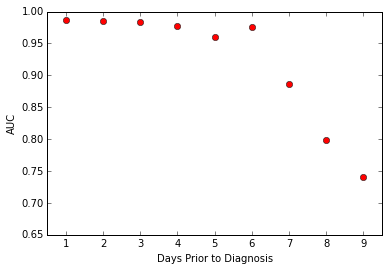

In [623]:
plt.plot(np.arange(1, 10), np.mean(np.array(clf_results).reshape((9, 3)), axis = 1), 'ro')
plt.xlabel('Days Prior to Diagnosis')
plt.ylabel('AUC')
plt.xticks(range(10))
plt.xlim([.5, 9.5])
plt.ylim([0.65, 1.0])
plt.show()

In [520]:
sum(X_train_cv_fs[:, 0] > 200)/X_train_cv_fs.shape[0]

0.11511354737666406

In [515]:
clf_results

[0.9860698564802611]

In [465]:
model_averages = np.mean(np.array(clf_results).reshape((5, 3)), axis = 1)

In [437]:
a = []
[a.append([x, y, z]) for x, y, z in zip(columns[0], scores[0], [dynamic_names[i] for i in columns[0]])]
a = pd.DataFrame(a).sort(1)

In [410]:
a = np.array(a)

In [399]:
d = [dynamic_names[i] for i in columns[0]]

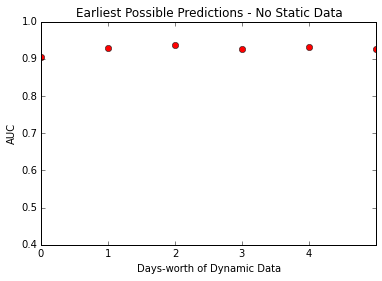

In [439]:
plt.plot(clf_results, 'ro')
plt.title('Earliest Possible Predictions - No Static Data')
plt.ylabel('AUC')
plt.xlabel('Days-worth of Dynamic Data')
plt.ylim([.4, 1])
plt.xticks(range(5))
plt.show()

In [388]:
new_features = []
count = []
for i in range(num_folds):
    [count.append(i) for i in columns[i]]
for i in Counter(count).most_common():
    if i[1] == num_folds:
        new_features.append(int(i[0]))
[print(dynamic_names[i]) for i in new_features]

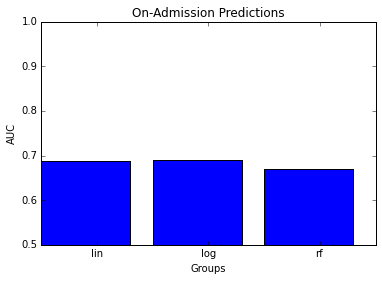

In [491]:
plt.bar(range(3), clf_results)
plt.title('On-Admission Predictions')
plt.xticks(np.arange(0.5, 3.5, 1), clf_list)
plt.xlabel('Groups')
plt.ylabel('AUC')
plt.ylim([0.5, 1.0])
plt.show()

In [192]:
intersection_list = []
for p in range(len(percentile_list)):
    intersection = []
    for i in columns:
        intersection.append(i[0][p])
    intersection_list.append(intersection)
intersection = []
for row in intersection_list:
    new = []
    for i in row:
        [new.append(a) for a in i]
    new = list(set(new))
    [print(dynamic_names[i]) for i in new]

50893_1
50912_1
50960_1
50893_1
50912_1
52_1
50960_1
50893_1
51221_1
50912_1
52_1
50960_1


In [176]:
for i in range(len(intersection_list)):
    intersection_list[i] = [list(a) for a in intersection_list[i]]

In [185]:
new = []
for i in intersection_list[0]:
    [new.append(a) for a in i]

In [214]:
dynamic_data = pd.read_csv('./preprocessor/output_dynamics_MRSA_new.csv', header = 0)
dynamic_names = []

for i in range(5):
    [dynamic_names.append(str(z)) for z in dynamic_data.columns.values[3:]]


In [226]:
dynamic_set_1 = ['51221', '51222','51248', '51249', '51250','51265','51277','51279','51301','50868','50882','50893','50902','50912','50931','50960','50970','50971','50983','51006']
dynamic_set_2 = ['51','52','113','184','211','454','455','456','618','646','678','679','723','5813','5815','5817','5819','5820','8368','8441','8547','8549','8551','8553','8554','220045','220046','220047','220050','220051','220052','220056','220058','220074','220179','220180','220181','220210','220277','220739','223751','223752','223761','223769','223770','223900','223901','224161','224162']
dynamic_set_3 = ['CMED','CSURG','DENT','ENT','GU','GYN','MED','NB','NBB','NMED','NSURG','OBS','ORTHO','OMED','PSURG','PSYCH','SURG','TRAUM','TSURG','VSURG']
dynamic_set_4 = ['high_antib', 'antib', 'h2', 'ppi']
dynamic_set_5 = ['YEAST','GRAM NEGATIVE ROD(S)','PSEUDOMONAS AERUGINOSA','KLEBSIELLA PNEUMONIAE','ENTEROCOCCUS SP.','ESCHERICHIA COLI','PROTEUS MIRABILIS','ENTEROBACTER CLOACAE','KLEBSIELLA OXYTOCA','ACINETOBACTER BAUMANNII','SERRATIA MARCESCENS','ENTEROBACTER AEROGENES']
name_df = pd.DataFrame(dynamic_names, columns = ['feature'])
name_df[name_df.feature.isin(dynamic_set_3)].index

Int64Index([ 44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
             57,  58,  59,  60,  61,  62,  63, 124, 125, 126, 127, 128, 129,
            130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
            143, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
            216, 217, 218, 219, 220, 221, 222, 223, 284, 285, 286, 287, 288,
            289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
            302, 303, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374,
            375, 376, 377, 378, 379, 380, 381, 382, 383],
           dtype='int64')

In [111]:
dynamic_data = pd.read_csv('./preprocessor/output_dynamics_MRSA_new.csv', header = 0)
dynamic_names = []
for i in range(5):
    [dynamic_names.append(str(z) + '_%i' % (i + 1)) for z in dynamic_data.columns.values[2:]]

In [363]:
new_features

[384,
 129,
 386,
 131,
 262,
 385,
 264,
 307,
 141,
 144,
 145,
 146,
 147,
 24,
 282,
 28,
 387,
 287,
 289,
 305,
 291,
 42,
 301,
 47,
 304,
 49,
 306,
 51,
 182,
 184,
 61,
 64,
 65,
 66,
 67,
 202,
 207,
 209,
 211,
 221,
 224,
 225,
 226,
 227,
 104,
 108,
 367,
 369,
 371,
 122,
 381,
 127]

In [140]:
[print(dynamic_names[i]) for i in intersection[2]]

50893_1
50912_1
50960_1


[None, None, None]

In [362]:
new_features = []
count = []
for i in range(num_folds):
    [count.append(i) for i in columns[i]]
for i in Counter(count).most_common():
    if i[1] == num_folds:
        new_features.append(i[0])
# X_train_fs, X_test_fs, y_train, y_test = train_test_split(dynamic[new_features], label, test_size = .3, random_state = 42)

In [32]:
 print('----- Adding Overlap Constraints -----')

# Chosen Percentiles
run = 'd'
static_stop = 1
dynamic_stop = 3
temporal_stop = 2

lower_limit = 10

temp_set = []
temp = []

lin_s_auc = []
rbf_s_auc = []
rf_s_auc = []
lin_d_auc = []
rbf_d_auc = []
rf_d_auc = []
lin_t_auc = []
rbf_t_auc = []
rf_t_auc = []



if run == 's':
    new_features_s = []
    for j in range(0, 18):
        temp_set = []
        count = []
        for i in np.arange(j, 180, 18):
            [count.append(i) for i in chosen_columns_s[i]]
            temp_set.append(set(chosen_columns_s[i]))
            temp.append(set.intersection(*temp_set))
        if j == static_stop:
            break
    for i in Counter(count).most_common():
        if i[1] >= lower_limit:
            new_features_s.append(i[0])
    X_train_s_fs, X_test_s_fs, y_train_s, y_test_s = train_test_split(static[new_features_s], label, test_size = .3, random_state = 42)
#     rbf_probs_s = run_clf('rbf', X_train_s_fs, y_train_s, X_test_s_fs, costSensitive)[0]
#     lin_probs_s = run_clf('lin', X_train_s_fs, y_train_s, X_test_s_fs, costSensitive)[0]
#     rf_probs_s = run_clf('rf', X_train_s_fs, y_train_s, X_test_s_fs, costSensitive)[0]
#     lin_s_auc.append(roc_auc_score(y_test_s, lin_probs_s))
#     rbf_s_auc.append(roc_auc_score(y_test_s, rbf_probs_s))
#     rf_s_auc.append(roc_auc_score(y_test_s, rf_probs_s))
    print('Done with run %i.' % (lower_limit + 1))

if run == 'd':
    new_features_d = []
    for j in range(10, 18):
        temp_set = []
        count = []
        for i in np.arange(j, 180, 18):
            [count.append(i) for i in chosen_columns_d[i]]
            temp_set.append(set(chosen_columns_d[i]))
            temp.append(set.intersection(*temp_set))
        if j == dynamic_stop:
            break

    for i in Counter(count).most_common():
        if i[1] >= lower_limit:
            new_features_d.append(i[0])
    X_train_d_fs, X_test_d_fs, y_train_d, y_test_d = train_test_split(dynamic[new_features_d], label, test_size = .3, random_state = 42)
#     rbf_probs_d = run_clf('rbf', X_train_d_fs, y_train_d, X_test_d_fs, costSensitive)[0]
#     lin_probs_d = run_clf('lin', X_train_d_fs, y_train_d, X_test_d_fs, costSensitive)[0]
#     rf_probs_d = run_clf('rf', X_train_d_fs, y_train_d, X_test_d_fs, costSensitive)[0]
#     lin_d_auc.append(roc_auc_score(y_test_d, lin_probs_d))
#     rbf_d_auc.append(roc_auc_score(y_test_d, rbf_probs_d))
#     rf_d_auc.append(roc_auc_score(y_test_d, rf_probs_d))
    print('Done with run %i.' % (lower_limit + 1))
if run == 't':
    new_features_t = []
    for j in range(10, 18):
        temp_set = []
        count = []
        for i in np.arange(j, 180, 18):
            [count.append(i) for i in chosen_columns_t[i]]
            temp_set.append(set(chosen_columns_t[i]))
            temp.append(set.intersection(*temp_set))
        if j == temporal_stop:
            break

    for i in Counter(count).most_common():
        if i[1] >= lower_limit:
            new_features_t.append(i[0])
    X_train_t_fs, X_test_t_fs, y_train_t, y_test_t = train_test_split(temporalOriginal[new_features_t], label, test_size = .3, random_state = 42)
#     rbf_probs_t = run_clf('rbf', X_train_t_fs, y_train_t, X_test_t_fs, costSensitive)[0]
#     lin_probs_t = run_clf('lin', X_train_t_fs, y_train_t, X_test_t_fs, costSensitive)[0]
#     rf_probs_t = run_clf('rf', X_train_t_fs, y_train_t, X_test_t_fs, costSensitive)[0]
#     lin_t_auc.append(roc_auc_score(y_test_t, lin_probs_t))
#     rbf_t_auc.append(roc_auc_score(y_test_t, rbf_probs_t))
#     rf_t_auc.append(roc_auc_score(y_test_t, rf_probs_t))
    print('Done with run %i.' % (lower_limit + 1))
print('Done!')

----- Adding Overlap Constraints -----


IndexError: list index out of range

In [21]:
X_test_d_fs.to_csv('X_test_d_fs_uniform.csv', index = 0)

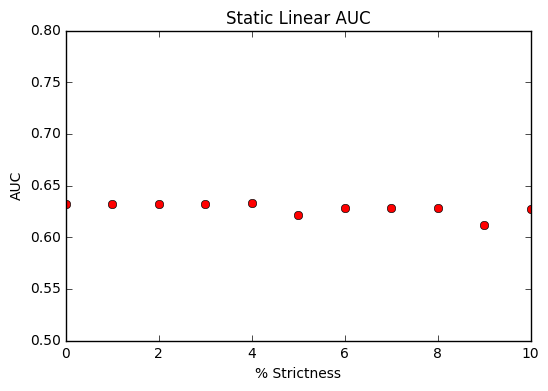

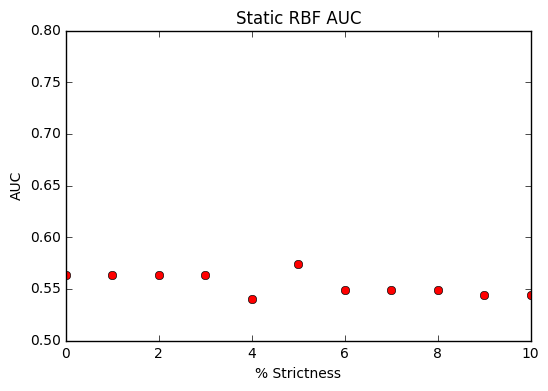

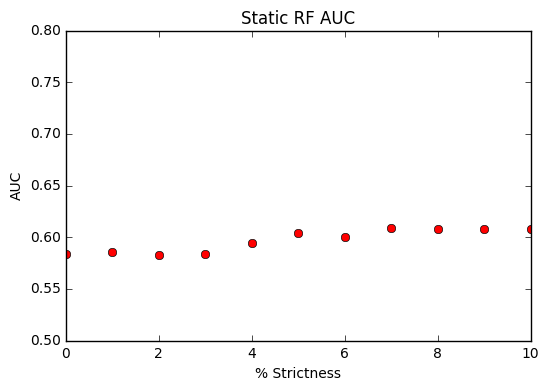

In [136]:
%matplotlib inline
plt.plot(range(11), lin_s_auc, 'ro')
plt.axis([0, 10, .5, .8])
plt.xlabel('% Strictness')
plt.ylabel('AUC')
plt.title('Static Linear AUC')
plt.show()
plt.plot(range(11), rbf_s_auc, 'ro')
plt.axis([0, 10, .5, .8])
plt.xlabel('% Strictness')
plt.ylabel('AUC')
plt.title('Static RBF AUC')
plt.show()
plt.plot(range(11), rf_s_auc, 'ro')
plt.axis([0, 10, .5, .8])
plt.xlabel('% Strictness')
plt.ylabel('AUC')
plt.title('Static RF AUC')
plt.show()

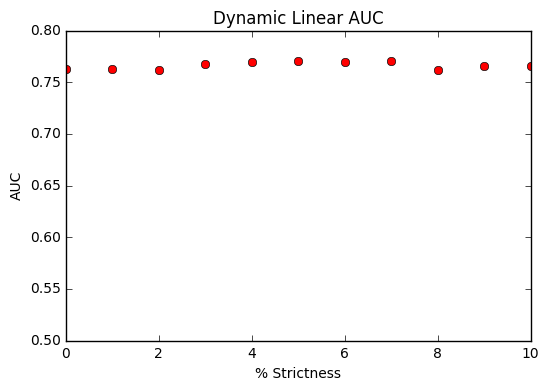

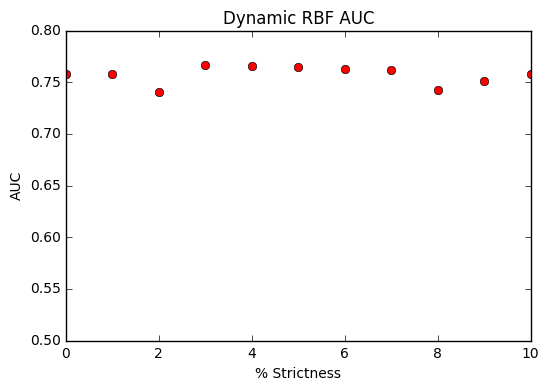

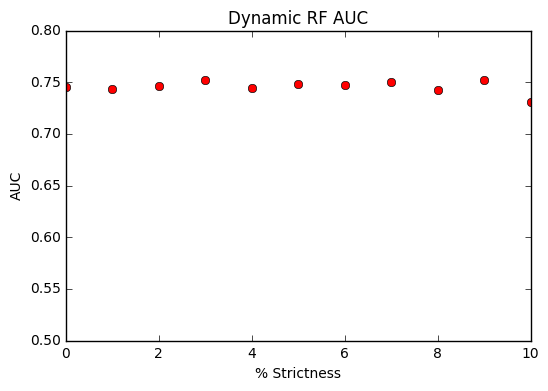

In [144]:
%matplotlib inline
plt.plot(range(11), lin_d_auc, 'ro')
plt.axis([0, 10, .5, .8])
plt.xlabel('% Strictness')
plt.ylabel('AUC')
plt.title('Dynamic Linear AUC')
plt.show()
plt.plot(range(11), rbf_d_auc, 'ro')
plt.axis([0, 10, .5, .8])
plt.xlabel('% Strictness')
plt.ylabel('AUC')
plt.title('Dynamic RBF AUC')
plt.show()
plt.plot(range(11), rf_d_auc, 'ro')
plt.axis([0, 10, .5, .8])
plt.xlabel('% Strictness')
plt.ylabel('AUC')
plt.title('Dynamic RF AUC')
plt.show()

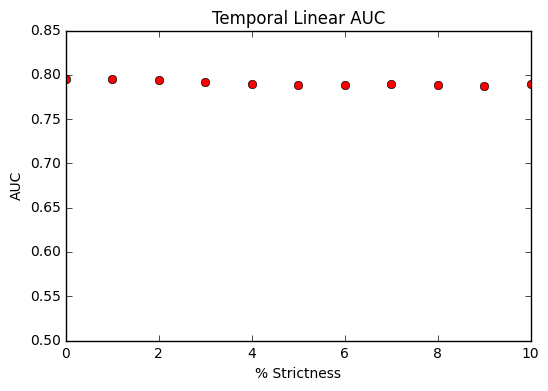

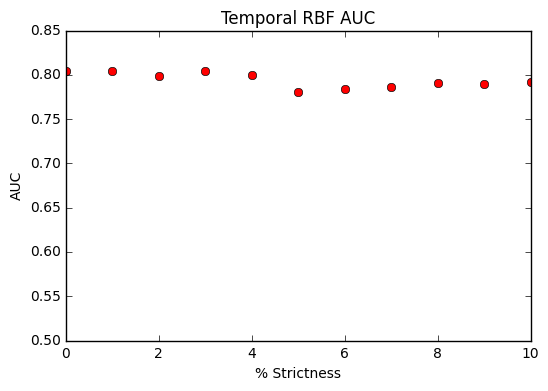

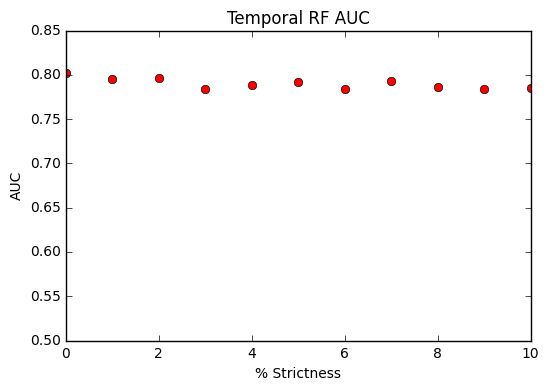

In [147]:
%matplotlib inline
plt.plot(range(11), lin_t_auc, 'ro')
plt.axis([0, 10, .5, .85])
plt.xlabel('% Strictness')
plt.ylabel('AUC')
plt.title('Temporal Linear AUC')
plt.show()
plt.plot(range(11), rbf_t_auc, 'ro')
plt.axis([0, 10, .5, .85])
plt.xlabel('% Strictness')
plt.ylabel('AUC')
plt.title('Temporal RBF AUC')
plt.show()
plt.plot(range(11), rf_t_auc, 'ro')
plt.axis([0, 10, .5, .85])
plt.xlabel('% Strictness')
plt.ylabel('AUC')
plt.title('Temporal RF AUC')
plt.show()

In [4]:
new_features_s = [19, 4, 7, 10]
new_features_d = [260, 11, 273, 18, 350, 24, 289, 40, 297, 299, 301, 48, 50, 307, 309, 311, 312, 52, 58, 60, 317, 318, 63, 66, 267, 68, 69, 71, 74, 403, 343, 399, 356, 101, 401, 107, 402, 372, 62, 380, 382, 384, 131, 133, 390, 135, 392, 394, 395, 141, 143, 400, 145, 146, 149, 150, 151, 152, 154, 65, 190, 214, 216, 218, 224, 226, 228, 229, 232, 234, 235]
new_features_t = [16, 1049, 32, 1065, 1066, 1067, 48, 50, 1078, 63, 64, 1091, 1093, 1094, 1097, 1098, 1099, 80, 1107, 1108, 1109, 1112, 1113, 1114, 1115, 1116, 1117, 1119, 96, 104, 1133, 1135, 112, 1139, 1140, 1145, 1146, 1147, 1148, 1149, 1151, 128, 130, 1156, 1157, 1165, 143, 144, 1171, 1172, 1173, 1178, 1179, 1181, 1183, 160, 1193, 176, 1204, 181, 192, 208, 224, 240, 1269, 256, 1284, 1290, 1291, 272, 288, 180, 304, 320, 328, 352, 1205, 354, 367, 368, 370, 384, 386, 391, 392, 397, 399, 400, 402, 407, 408, 413, 415, 416, 418, 424, 431, 432, 434, 447, 448, 450, 456, 463, 466, 479, 482, 495, 498, 512, 514, 520, 527, 528, 530, 536, 543, 544, 546, 551, 559, 562, 578, 592, 594, 600, 607, 608, 610, 624, 626, 640, 642, 643, 646, 649, 650, 651, 653, 654, 656, 658, 663, 671, 672, 674, 688, 690, 704, 706, 711, 712, 717, 719, 771, 773, 774, 777, 778, 779, 132, 803, 806, 810, 835, 837, 838, 841, 842, 843, 1167, 933, 937, 939, 966, 995, 996, 997, 998, 1001, 1002, 1003, 1004, 1005, 1007, 1011, 1013, 1014, 1017, 1018, 1019]

In [7]:
# ugly code alert

chosen_s_features = [10, 19, 4, 7]
chosen_d_features = [384, 131, 260, 133, 390, 135, 394, 11, 267, 141, 395, 399, 400, 145, 18, 146, 273, 149, 150, 151, 24, 152, 154, 402, 403, 158, 289, 40, 297, 299, 301, 48, 177, 50, 307, 52, 311, 184, 312, 58, 317, 62, 63, 190, 65, 66, 318, 68, 69, 320, 71, 72, 74, 214, 343, 216, 218, 94, 350, 224, 401, 228, 101, 229, 356, 232, 234, 107, 235, 372, 380, 382]
chosen_t_features = [512, 514, 520, 527, 16, 528, 530, 536, 1049, 543, 32, 544, 546, 1059, 551, 1065, 1066, 1067, 559, 48, 50, 562, 1078, 63, 64, 578, 1091, 1093, 1094, 1097, 1098, 1099, 80, 592, 594, 1107, 1108, 1109, 600, 1112, 1113, 1114, 1115, 1116, 1117, 607, 96, 608, 98, 610, 1119, 104, 1133, 1135, 112, 624, 114, 626, 1139, 1140, 1145, 1146, 1147, 1148, 1149, 1151, 128, 640, 130, 642, 132, 643, 646, 1155, 1156, 649, 650, 651, 1157, 653, 654, 143, 144, 656, 658, 1171, 1165, 1172, 1173, 663, 1167, 1181, 671, 160, 672, 674, 1183, 176, 688, 690, 180, 181, 1204, 1205, 192, 704, 706, 711, 712, 717, 719, 208, 224, 240, 1269, 255, 256, 771, 1284, 773, 774, 777, 778, 779, 1290, 1291, 272, 288, 803, 805, 806, 809, 810, 811, 304, 320, 835, 837, 838, 328, 841, 842, 843, 335, 338, 352, 354, 367, 368, 370, 384, 386, 391, 392, 397, 399, 400, 402, 407, 408, 413, 415, 416, 418, 933, 423, 424, 937, 938, 939, 429, 431, 432, 434, 447, 448, 450, 966, 456, 463, 466, 479, 482, 995, 996, 997, 998, 1001, 1002, 1003, 1004, 1005, 495, 1007, 498, 1011, 1013, 1014, 1017, 1018, 1019]


In [5]:
static_names = ['first_admit_age', 'antib', 'kidney', 'cdiff', 'diab',
       'admission_type_ELECTIVE', 'admission_type_EMERGENCY',
       'admission_type_NEWBORN', 'admission_type_URGENT',
       'admission_location_** INFO NOT AVAILABLE **',
       'admission_location_CLINIC REFERRAL/PREMATURE',
       'admission_location_EMERGENCY ROOM ADMIT',
       'admission_location_PHYS REFERRAL/NORMAL DELI',
       'admission_location_TRANSFER FROM HOSP/EXTRAM',
       'admission_location_TRANSFER FROM OTHER HEALT',
       'admission_location_TRANSFER FROM SKILLED NUR',
       'insurance_Government', 'insurance_Medicaid', 'insurance_Medicare',
       'insurance_Private', 'insurance_Self Pay', 'religion_CATHOLIC',
       'religion_JEWISH', 'religion_NOT SPECIFIED', 'religion_OTHER',
       'religion_PROTESTANT QUAKER', 'religion_UNOBTAINABLE',
       'marital_status_DIVORCED', 'marital_status_MARRIED',
       'marital_status_SEPARATED', 'marital_status_SINGLE',
       'marital_status_UNKNOWN (DEFAULT)', 'marital_status_WIDOWED',
       'ethnicity_OTHER', 'ethnicity_WHITE', 'gender_F', 'gender_M']
dynamic_names = list(pd.read_csv('dynamic_feature_names.csv', header = -1)[0])
temporal_names = list(pd.read_csv('temporal_feature_names.csv', header = -1)[0])

In [95]:
# [static_names[i] for i in chosen_s_features]
[dynamic_names[i] for i in new_features]
# [temporal_names[i] for i in chosen_t_features]

['51248',
 '50902',
 '50912',
 'NMED',
 '50983',
 '456',
 '51265',
 'VSURG',
 '51301',
 '8441',
 '8551',
 '678',
 '113',
 'TSURG',
 'MED',
 '5820',
 'CMED',
 'CSURG',
 '8551',
 'ENT',
 '113',
 'PSURG',
 'PSYCH',
 'OBS',
 'NMED',
 'GU',
 'VSURG',
 'DENT',
 'NB',
 'GYN',
 'ORTHO',
 'high_antib',
 'PSURG',
 'NMED',
 'PSYCH',
 'high_antib',
 'antib',
 'h2',
 'ppi',
 'YEAST',
 'ENTEROCOCCUS SP.',
 '50931',
 '51222',
 '50893',
 '50902',
 '5813',
 '50971',
 '455',
 '51250',
 '51279',
 '8549',
 '646',
 '8554',
 '723',
 'NSURG',
 'OBS',
 '5819',
 'GU',
 '5815',
 'TRAUM',
 '8554',
 'OMED',
 'TSURG',
 'SURG',
 'MED',
 'CSURG',
 'CMED',
 'DENT',
 'NB',
 'ENT',
 'OMED',
 'SURG',
 'VSURG',
 'PSYCH',
 'high_antib',
 'antib',
 'h2',
 'los',
 '51265',
 '50882',
 '50893',
 'high_antib',
 '50970',
 '51249',
 '51277',
 'MED',
 '618',
 '50868',
 '5817',
 '8553',
 'NSURG',
 'OBS',
 'GU',
 'CMED',
 'DENT',
 '8549',
 'GU',
 'ORTHO',
 'NBB',
 'CSURG',
 'VSURG',
 'PSYCH',
 'high_antib',
 '50868',
 '50882',
 '51

In [31]:
# chopped experiment
chosen_s_features = [10, 19, 4, 7]
chosen_d_features = [0, 11, 18, 24, 48, 50, 52, 58, 59, 60, 62, 63, 66, 67, 68, 69, 71, 74, 80, 83, 94, 101, 107, 131, 133, 135, 141, 142, 143, 145, 146, 149, 150, 151, 152, 154, 156, 158, 166, 177, 184, 190, 206, 214, 216, 218, 224, 225, 226, 228, 229, 232, 234, 235, 249, 260, 267, 289, 297, 299, 301, 307, 308, 309, 311, 312, 316, 317, 332, 343, 350, 372, 380, 382, 384, 390, 391, 392, 394, 395, 399, 400, 401, 403, 406, 408]
chosen_t_features = [1, 3, 4, 5, 7, 9, 10, 11, 16, 17, 18, 20, 21, 22, 23, 24, 25, 29, 31, 32, 33, 34, 36, 37, 38, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 61, 62, 63, 64, 65, 66, 68, 69, 71, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 126, 127, 128, 129, 130, 131, 132, 133, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 152, 157, 159, 160, 161, 162, 163, 164, 165, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 228, 230, 231, 232, 237, 238, 239, 240, 241, 242, 244, 246, 252, 253, 254, 255, 256, 257, 258, 260, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 285, 287, 288, 289, 290, 291, 292, 293, 294, 296, 297, 298, 299, 301, 302, 303, 304, 305, 306, 307, 308, 310, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 328, 329, 330, 331, 332, 333, 335, 337, 338, 339, 340, 342, 344, 345, 346, 347, 351, 352, 354, 355, 357, 358, 360, 361, 362, 363, 364, 365, 366, 367, 368, 370, 372, 373, 375, 376, 377, 378, 379, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 465, 466, 467, 468, 469, 471, 473, 474, 475, 476, 477, 478, 479, 481, 482, 484, 485, 487, 493, 494, 495, 497, 498, 499, 500, 501, 503, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 519, 520, 521, 522, 523, 525, 526, 527, 528, 529, 530, 531, 533, 534, 536, 537, 538, 539, 541, 543, 544, 545, 546, 548, 549, 550, 551, 552, 553, 557, 558, 559, 560, 562, 566, 567, 573, 574, 576, 578, 579, 580, 581, 582, 585, 586, 587, 590, 591, 592, 593, 594, 595, 597, 598, 600, 601, 602, 603, 604, 605, 606, 607, 608, 610, 614, 617, 622, 624, 626, 630, 633, 635, 638, 639, 640, 641, 642, 643, 644, 645, 646, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 665, 666, 667, 668, 669, 670, 671, 672, 674, 678, 680, 686, 687, 688, 690, 691, 692, 693, 694, 697, 698, 699, 700, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 735, 737, 740, 742, 743, 744, 753, 759, 760, 769, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 783, 785, 791, 792, 801, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 817, 823, 824, 833, 835, 837, 838, 839, 840, 841, 842, 843, 849, 854, 855, 856, 865, 867, 869, 870, 871, 872, 873, 874, 875, 881, 887, 888, 897, 899, 901, 903, 904, 905, 906, 907, 908, 909, 911, 913, 918, 919, 920, 924, 925, 927, 929, 931, 933, 934, 935, 936, 937, 938, 939, 945, 947, 949, 950, 951, 952, 953, 954, 955, 961, 963, 965, 966, 967, 968, 969, 970, 971, 972, 973, 975, 977, 979, 980, 982, 983, 984, 986, 987, 993, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1023, 1025, 1031, 1032, 1041, 1043, 1044, 1045, 1046, 1047, 1048, 1050, 1055, 1057, 1059, 1061, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1073, 1075, 1076, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1089, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1105, 1107, 1108, 1109, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1121, 1123, 1124, 1125, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1137, 1139, 1140, 1141, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1153, 1155, 1156, 1157, 1159, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1169, 1171, 1172, 1173, 1175, 1178, 1179, 1180, 1181, 1182, 1183, 1185, 1187, 1188, 1189, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1199, 1201, 1203, 1204, 1205, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1215, 1217, 1220, 1221, 1223, 1224, 1225, 1228, 1229, 1231, 1233, 1235, 1236, 1239, 1240, 1242, 1243, 1244, 1245, 1247, 1249, 1251, 1252, 1253, 1255, 1256, 1258, 1259, 1260, 1265, 1267, 1268, 1269, 1271, 1272, 1274, 1275, 1277, 1279, 1281, 1283, 1284, 1285, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1295, 1297, 1300, 1301, 1303, 1304, 1306, 1311, 1313, 1315, 1316, 1319, 1320, 1322, 1323, 1324, 1325, 1327]

# Chi2

In [40]:
## Next create our final training sets with features selected
X_train_s_fs, X_test_s_fs, y_train_s, y_test_s = train_test_split(static[chosen_s_features], label, test_size = .3, random_state = 42)
X_train_d_fs, X_test_d_fs, y_train_d, y_test_d = train_test_split(dynamic[chosen_d_features], label, test_size = .3, random_state = 42)
X_train_t_fs, X_test_t_fs, y_train_t, y_test_t = train_test_split(temporal[chosen_t_features], label, test_size = .3, random_state = 42)

In [40]:
static = static[chosen_s_features]
dynamic = dynamic[chosen_d_features]
temporal = temporal[chosen_t_features]

In [57]:
X_test_s_fs.to_csv('X_test_s_fs_chopped.csv', index = 0)

# Classifier Combinations

In [44]:
costSensitive = False

# code for combining predictions made by different classifiers on different feature sets. E.g. static_rbf with
# dynamic_rbf, or static_lin with temporal_lin, etc.

rbf_probs_s = run_clf('rbf', X_train_s_fs, y_train_s, X_test_s_fs, costSensitive)[0]
lin_probs_s = run_clf('lin', X_train_s_fs, y_train_s, X_test_s_fs, costSensitive)[0]
rf_probs_s = run_clf('rf', X_train_s_fs, y_train_s, X_test_s_fs, costSensitive)[0]

staticProbabilities = pd.DataFrame({'rbf':rbf_probs_s, # this is a dataframe containing a column of predictions
                                    'lin':lin_probs_s, # made by each classifier chosen above for static features
                                    'rf':rf_probs_s})

rbf_probs_d = run_clf('rbf', X_train_d_fs, y_train_d, X_test_d_fs, costSensitive)[0]
lin_probs_d = run_clf('lin', X_train_d_fs, y_train_d, X_test_d_fs, costSensitive)[0]
rf_probs_d = run_clf('rf', X_train_d_fs, y_train_d, X_test_d_fs, costSensitive)[0]

dynamicProbabilities = pd.DataFrame({'rbf':rbf_probs_d,
                                    'lin':lin_probs_d,
                                    'rf':rf_probs_d})

rbf_probs_t = run_clf('rbf', X_train_t_fs, y_train_t, X_test_t_fs, costSensitive)[0]
lin_probs_t = run_clf('lin', X_train_t_fs, y_train_t, X_test_t_fs, costSensitive)[0]
rf_probs_t = run_clf('rf', X_train_t_fs, y_train_t, X_test_t_fs, costSensitive)[0]

temporalProbabilities = pd.DataFrame({'rbf':rbf_probs_t,
                                    'lin':lin_probs_t,
                                    'rf':rf_probs_t})

# now we have 3 dataframes: one for static predicted probabilities, one for dynamic predicted probabilities,
# and one for temporal predicted probabilities.

# Base Classifiers - Selected Features

In [45]:
static_lin = roc_auc_score(y_test_s, lin_probs_s)
static_rbf = roc_auc_score(y_test_s, rbf_probs_s)
static_rf = roc_auc_score(y_test_s, rf_probs_s)

dynamic_lin = roc_auc_score(y_test_s, lin_probs_d)
dynamic_rbf = roc_auc_score(y_test_s, rbf_probs_d)
dynamic_rf = roc_auc_score(y_test_s, rf_probs_d)

temporal_lin = roc_auc_score(y_test_s, lin_probs_t)
temporal_rbf = roc_auc_score(y_test_s, rbf_probs_t)
temporal_rf = roc_auc_score(y_test_s, rf_probs_t)
print('Static Linear SVM:', static_lin)
print('Static RBF SVM:',static_rbf)
print('Static Random Forest:', static_rf)
print()
print('Dynamic Linear SVM:',dynamic_lin)
print('Dynamic RBF SVM:',dynamic_rbf)
print('Dynamic Random Forest:', dynamic_rf)
print()
print('Temporal Linear SVM:',temporal_lin)
print('Temporal RBF SVM:',temporal_rbf)
print('Temporal Random Forest:', temporal_rf)

Static Linear SVM: 0.626543209877
Static RBF SVM: 0.54387755102
Static Random Forest: 0.608150667674

Dynamic Linear SVM: 0.756311413454
Dynamic RBF SVM: 0.778760393046
Dynamic Random Forest: 0.819085411943

Temporal Linear SVM: 0.816502897455
Temporal RBF SVM: 0.81539430587
Temporal Random Forest: 0.839027462837


In [213]:
rf_probs_d_binary = []
for i in rf_probs_d:
    if i < 0.5:
        rf_probs_d_binary.append(0)
    else:
        rf_probs_d_binary.append(1)
print(classification_report(rf_probs_d_binary, y_test_s))

             precision    recall  f1-score   support

          0       0.84      0.75      0.79       305
          1       0.48      0.62      0.54       112

avg / total       0.75      0.71      0.73       417



# Classifier Combinations

In [46]:
# next, combine just the same classifier from each of these 3 feature sets so that we can test combination weights
# these are all (972 x 3)

linProbs = np.transpose(np.array([staticProbabilities.lin, dynamicProbabilities.lin, temporalProbabilities.lin]))
rbfProbs = np.transpose(np.array([staticProbabilities.rbf, dynamicProbabilities.rbf, temporalProbabilities.rbf]))
rfProbs = np.transpose(np.array([staticProbabilities.rf, dynamicProbabilities.rf, temporalProbabilities.rf]))

In [291]:
# now to test out 'all' combinations of these 3 data sets

#featureSet = rfProbs # choose your feature set here
num_folds = 5
# create a list of all possible combinations of 3 numbers between 0 and 1 that sum to 1
combo_list = []
static_range = np.arange(0, 1, .1)
dynamic_range = np.arange(0, 1, .1)
temporal_range = np.arange(0, 1, .1)
combo_list.append([(s, d, t) for s in static_range
                   for d in dynamic_range
                   for t in temporal_range
                   if (sum([s, d, t]) == 1)])
combo_list = combo_list[0]      
    
lin_full_combo_AUC = []
rbf_full_combo_AUC = []
rf_full_combo_AUC = []
kf = KFold(n_splits = num_folds, shuffle = True)

for i in combo_list: # apply weighted average to each feature set
    fold = 1
    lin_combo_AUC = []
    rbf_combo_AUC = []
    rf_combo_AUC = []
    for train, test in kf.split(np.arange(X_train_s_fs.shape[0])):
        print('----- running for fold %i -----' % fold)
        CV_X_train_s_fs, CV_X_test_s_fs, CV_y_train_s, CV_y_test_s = X_train_s_fs[train,:], X_train_s_fs[test,:], y_train_s[train], y_train_s[test]
        CV_X_train_d_fs, CV_X_test_d_fs, CV_y_train_d, CV_y_test_d = X_train_d_fs[train,:], X_train_d_fs[test,:], y_train_d[train], y_train_d[test]
        CV_X_train_t_fs, CV_X_test_t_fs, CV_y_train_t, CV_y_test_t = X_train_t_fs[train,:], X_train_t_fs[test,:], y_train_t[train], y_train_t[test]
         
        rbf_probs_s = run_clf('rbf', CV_X_train_s_fs, CV_y_train_s, CV_X_test_s_fs)
        lin_probs_s = run_clf('lin', CV_X_train_s_fs, CV_y_train_s, CV_X_test_s_fs)
        rf_probs_s = run_clf('rf', CV_X_train_s_fs, CV_y_train_s, CV_X_test_s_fs)

        staticProbabilities = pd.DataFrame({'rbf':rbf_probs_s, 
                                            'lin':lin_probs_s, 
                                            'rf':rf_probs_s})

        rbf_probs_d = run_clf('rbf', CV_X_train_d_fs, CV_y_train_d, CV_X_test_d_fs)
        lin_probs_d = run_clf('lin', CV_X_train_d_fs, CV_y_train_d, CV_X_test_d_fs)
        rf_probs_d = run_clf('rf', CV_X_train_d_fs, CV_y_train_d, CV_X_test_d_fs)

        dynamicProbabilities = pd.DataFrame({'rbf':rbf_probs_d,
                                            'lin':lin_probs_d,
                                            'rf':rf_probs_d})

        rbf_probs_t = run_clf('rbf', CV_X_train_t_fs, CV_y_train_t, CV_X_test_t_fs)
        lin_probs_t = run_clf('lin', CV_X_train_t_fs, CV_y_train_t, CV_X_test_t_fs)
        rf_probs_t = run_clf('rf', CV_X_train_t_fs, CV_y_train_t, CV_X_test_t_fs)

        temporalProbabilities = pd.DataFrame({'rbf':rbf_probs_t,
                                            'lin':lin_probs_t,
                                            'rf':rf_probs_t})
        static_lin = roc_auc_score(CV_y_test_s, lin_probs_s)
        static_rbf = roc_auc_score(CV_y_test_s, rbf_probs_s)
        static_rf = roc_auc_score(CV_y_test_s, rf_probs_s)

        dynamic_lin = roc_auc_score(CV_y_test_s, lin_probs_d)
        dynamic_rbf = roc_auc_score(CV_y_test_s, rbf_probs_d)
        dynamic_rf = roc_auc_score(CV_y_test_s, rf_probs_d)

        temporal_lin = roc_auc_score(CV_y_test_s, lin_probs_t)
        temporal_rbf = roc_auc_score(CV_y_test_s, rbf_probs_t)
        temporal_rf = roc_auc_score(CV_y_test_s, rf_probs_t)

        linProbs = np.transpose(np.array([staticProbabilities.lin, dynamicProbabilities.lin, temporalProbabilities.lin]))
        rbfProbs = np.transpose(np.array([staticProbabilities.rbf, dynamicProbabilities.rbf, temporalProbabilities.rbf]))
        rfProbs = np.transpose(np.array([staticProbabilities.rf, dynamicProbabilities.rf, temporalProbabilities.rf]))
        
        lin_combo_AUC.append(roc_auc_score(CV_y_test_s, np.average(linProbs, axis = 1, weights = i)))
        rbf_combo_AUC.append(roc_auc_score(CV_y_test_s, np.average(rbfProbs, axis = 1, weights = i)))
        rf_combo_AUC.append(roc_auc_score(CV_y_test_s, np.average(rfProbs, axis = 1, weights = i)))
        fold += 1
    
    lin_full_combo_AUC.append(np.mean(lin_combo_AUC))
    rbf_full_combo_AUC.append(np.mean(rbf_combo_AUC))
    rf_full_combo_AUC.append(np.mean(rf_combo_AUC))
# print(combo_list[np.array(comboAUC).argmax()], 'is the best combination for this feature set with an AUC of',
#       max(np.array(comboAUC)))# print the best combination

print('done!')

NameError: name 'X_train_s_fs' is not defined

In [287]:
combo_list = []
static_range = np.arange(0, 1, .1)
dynamic_range = np.arange(0, 1, .1)
temporal_range = np.arange(0, 1, .1)
combo_list.append([(s, d, t, a, b, c, e, f, g)
                   for s in static_range
                   for d in dynamic_range
                   for t in temporal_range
                   for a in temporal_range
                   for b in temporal_range
                   for c in temporal_range
                   for e in temporal_range
                   for f in temporal_range
                   for g in temporal_range
                   if (sum([s, d, t, a, b, c, e, f, g]) == 1)])
combo_list = combo_list[0]
len(combo_list)

35187

In [290]:
np.save('combo_list', np.array(combo_list))

In [48]:
combo_list = np.load('combo_list.npy')

# PCA

In [239]:
#  Fitting PCA on training data, then projecting testing data into this vectorspace

static_pca = PCA(n_components = 20).fit(X_train_s)
X_train_s_pca = static_pca.transform(X_train_s)
X_test_s_pca = static_pca.transform(X_test_s)

dynamic_pca = PCA(n_components = 100).fit(X_train_d)
X_train_d_pca = dynamic_pca.transform(X_train_d)
X_test_d_pca = dynamic_pca.transform(X_test_d)

temporal_pca = PCA(n_components = 200).fit(X_train_t)
X_train_t_pca = temporal_pca.transform(X_train_t)
X_test_t_pca = temporal_pca.transform(X_test_t)

In [54]:
costSensitive = False

X_train_s_fs_sub, X_test_s_fs_sub, y_train_s_fs_sub, y_test_s_fs_sub = train_test_split(X_train_s_fs, y_train_s, test_size = .3, random_state = 21)
X_train_d_fs_sub, X_test_d_fs_sub, y_train_d_fs_sub, y_test_d_fs_sub = train_test_split(X_train_d_fs, y_train_s, test_size = .3, random_state = 21)
X_train_t_fs_sub, X_test_t_fs_sub, y_train_t_fs_sub, y_test_t_fs_sub = train_test_split(X_train_t_fs, y_train_s, test_size = .3, random_state = 21)

rbf_probs_s = run_clf('rbf', X_train_s_fs_sub, y_train_s_fs_sub, X_test_s_fs_sub, costSensitive)[0]
lin_probs_s = run_clf('lin', X_train_s_fs_sub, y_train_s_fs_sub, X_test_s_fs_sub, costSensitive)[0]
rf_probs_s = run_clf('rf', X_train_s_fs_sub, y_train_s_fs_sub, X_test_s_fs_sub, costSensitive)[0]

rbf_probs_d = run_clf('rbf', X_train_d_fs_sub, y_train_d_fs_sub, X_test_d_fs_sub, costSensitive)[0]
lin_probs_d = run_clf('lin', X_train_d_fs_sub, y_train_d_fs_sub, X_test_d_fs_sub, costSensitive)[0]
rf_probs_d = run_clf('rf', X_train_d_fs_sub, y_train_d_fs_sub, X_test_d_fs_sub, costSensitive)[0]

rbf_probs_t = run_clf('rbf', X_train_t_fs_sub, y_train_t_fs_sub, X_test_t_fs_sub, costSensitive)[0]
lin_probs_t = run_clf('lin', X_train_t_fs_sub, y_train_t_fs_sub, X_test_t_fs_sub, costSensitive)[0]
rf_probs_t = run_clf('rf', X_train_t_fs_sub, y_train_t_fs_sub, X_test_t_fs_sub, costSensitive)[0]

# static_lin = roc_auc_score(y_test_s, lin_probs_s)
# static_rbf = roc_auc_score(y_test_s, rbf_probs_s)
# static_rf = roc_auc_score(y_test_s, rf_probs_s)

# dynamic_lin = roc_auc_score(y_test_s, lin_probs_d)
# dynamic_rbf = roc_auc_score(y_test_s, rbf_probs_d)
# dynamic_rf = roc_auc_score(y_test_s, rf_probs_d)

# temporal_lin = roc_auc_score(y_test_s, lin_probs_t)
# temporal_rbf = roc_auc_score(y_test_s, rbf_probs_t)
# temporal_rf = roc_auc_score(y_test_s, rf_probs_t)

staticProbabilities = pd.DataFrame({'rbf':rbf_probs_s, # this is a dataframe containing a column of predictions
                                    'lin':lin_probs_s, # made by each classifier chosen above for static features
                                    'rf':rf_probs_s})

dynamicProbabilities = pd.DataFrame({'rbf':rbf_probs_d,
                                    'lin':lin_probs_d,
                                    'rf':rf_probs_d})

temporalProbabilities = pd.DataFrame({'rbf':rbf_probs_t,
                                    'lin':lin_probs_t,
                                    'rf':rf_probs_t})

# print('Static Linear SVM:', static_lin)
# print('Static RBF SVM:',static_rbf)
# print('Static Random Forest:', static_rf)
# print()
# print('Dynamic Linear SVM:',dynamic_lin)
# print('Dynamic RBF SVM:',dynamic_rbf)
# print('Dynamic Random Forest:', dynamic_rf)
# print()
# print('Temporal Linear SVM:',temporal_lin)
# print('Temporal RBF SVM:',temporal_rbf)
# print('Temporal Random Forest:', temporal_rf)

In [58]:
linProbs = np.transpose(np.array([staticProbabilities.lin, dynamicProbabilities.lin, temporalProbabilities.lin]))
rbfProbs = np.transpose(np.array([staticProbabilities.rbf, dynamicProbabilities.rbf, temporalProbabilities.rbf]))
rfProbs = np.transpose(np.array([staticProbabilities.rf, dynamicProbabilities.rf, temporalProbabilities.rf]))
fullProbs = np.concatenate((linProbs, rbfProbs, rfProbs), axis = 1)

In [59]:
fullProbs.shape

(292, 9)

In [61]:
# now to test out 'all' combinations of these 3 data sets

#featureSet = rfProbs # choose your feature set here
num_folds = 5
# create a list of all possible combinations of 3 numbers between 0 and 1 that sum to 1
# combo_list = []
# static_range = np.arange(0, 1, .05)
# dynamic_range = np.arange(0, 1, .05)
# temporal_range = np.arange(0, 1, .05)
# combo_list.append([(s, d, t) for s in static_range
#                    for d in dynamic_range
#                    for t in temporal_range
#                    if (sum([s, d, t]) == 1)])
# combo_list = combo_list[0]      
    
lin_full_combo_AUC = []
rbf_full_combo_AUC = []
rf_full_combo_AUC = []

#X_train_9, X_test_9, y_train_9, y_test_9 = train_test_split(fullProbs, y_test_s_pca_sub, test_size = .2, random_state = 21)
#X_train_rbf, X_test_rbf, y_train_rbf, y_test_rbf = train_test_split(rbfProbs, y_train_s_pca_sub, test_size = .2, random_state = 21)
#X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(rfProbs, y_train_s_pca_sub, test_size = .2, random_state = 21)

lin_combo_AUC = []
rbf_combo_AUC = []
rf_combo_AUC = []
full_probs_AUC = []

for i in combo_list: # apply weighted average to each feature set    
    #linProbs_avg = np.average(linProbs, axis = 1, weights = i)
    #rbfProbs_avg = np.average(rbfProbs, axis = 1, weights = i)
    #rfProbs_avg = np.average(rfProbs, axis = 1, weights = i)
    fullProbs_avg = np.average(fullProbs, axis = 1, weights = i)
    full_probs_AUC.append(roc_auc_score(y_test_s_fs_sub, fullProbs_avg))
#     lin_combo_AUC.append(roc_auc_score(y_test_s_pca_sub, linProbs_avg))
#     rbf_combo_AUC.append(roc_auc_score(y_test_s_pca_sub, rbfProbs_avg))
#     rf_combo_AUC.append(roc_auc_score(y_test_s_pca_sub, rfProbs_avg))

print('done!')

done!


In [62]:
np.array(full_probs_AUC).max()

0.80384460547504044

In [64]:
X_test_s_fs.shape

(417, 4)

In [70]:
rbf_probs_s = run_clf('rbf', X_train_s_fs, y_train_s, X_test_s_fs, costSensitive)[0]
lin_probs_s = run_clf('lin', X_train_s_fs, y_train_s, X_test_s_fs, costSensitive)[0]
rf_probs_s = run_clf('rf', X_train_s_fs, y_train_s, X_test_s_fs, costSensitive)[0]

rbf_probs_d = run_clf('rbf', X_train_d_fs, y_train_d, X_test_d_fs, costSensitive)[0]
lin_probs_d = run_clf('lin', X_train_d_fs, y_train_d, X_test_d_fs, costSensitive)[0]
rf_probs_d = run_clf('rf', X_train_d_fs, y_train_d, X_test_d_fs, costSensitive)[0]

rbf_probs_t = run_clf('rbf', X_train_t_fs, y_train_t, X_test_t_fs, costSensitive)[0]
lin_probs_t = run_clf('lin', X_train_t_fs, y_train_t, X_test_t_fs, costSensitive)[0]
rf_probs_t = run_clf('rf', X_train_t_fs, y_train_t, X_test_t_fs, costSensitive)[0]

# static_lin = roc_auc_score(y_test_s, lin_probs_s)
# static_rbf = roc_auc_score(y_test_s, rbf_probs_s)
# static_rf = roc_auc_score(y_test_s, rf_probs_s)

# dynamic_lin = roc_auc_score(y_test_s, lin_probs_d)
# dynamic_rbf = roc_auc_score(y_test_s, rbf_probs_d)
# dynamic_rf = roc_auc_score(y_test_s, rf_probs_d)

# temporal_lin = roc_auc_score(y_test_s, lin_probs_t)
# temporal_rbf = roc_auc_score(y_test_s, rbf_probs_t)
# temporal_rf = roc_auc_score(y_test_s, rf_probs_t)

staticProbabilities = pd.DataFrame({'rbf':rbf_probs_s, # this is a dataframe containing a column of predictions
                                    'lin':lin_probs_s, # made by each classifier chosen above for static features
                                    'rf':rf_probs_s})

dynamicProbabilities = pd.DataFrame({'rbf':rbf_probs_d,
                                    'lin':lin_probs_d,
                                    'rf':rf_probs_d})

temporalProbabilities = pd.DataFrame({'rbf':rbf_probs_t,
                                    'lin':lin_probs_t,
                                    'rf':rf_probs_t})

In [73]:
linProbs = np.transpose(np.array([staticProbabilities.lin, dynamicProbabilities.lin, temporalProbabilities.lin]))
rbfProbs = np.transpose(np.array([staticProbabilities.rbf, dynamicProbabilities.rbf, temporalProbabilities.rbf]))
rfProbs = np.transpose(np.array([staticProbabilities.rf, dynamicProbabilities.rf, temporalProbabilities.rf]))
fullProbs = np.concatenate((linProbs, rbfProbs, rfProbs), axis = 1)
fullProbs = np.average(fullProbs, axis = 1)#weights = combo_list[np.array(full_probs_AUC).argmax()])

In [69]:
best_weights

array([ 0. ,  0. ,  0.1,  0. ,  0.2,  0. ,  0.1,  0. ,  0.6])

In [74]:
print(roc_auc_score(y_test_s, fullProbs))

0.81967750063


# Testing PCA

In [241]:
rbf_probs_s = run_clf('rbf', X_train_s_pca, y_train_s, X_test_s_pca, costSensitive)[0]
lin_probs_s = run_clf('lin', X_train_s_pca, y_train_s, X_test_s_pca, costSensitive)[0]
rf_probs_s = run_clf('rf', X_train_s_pca, y_train_s, X_test_s_pca, costSensitive)[0]

rbf_probs_d = run_clf('rbf', X_train_d_pca, y_train_d, X_test_d_pca, costSensitive)[0]
lin_probs_d = run_clf('lin', X_train_d_pca, y_train_d, X_test_d_pca, costSensitive)[0]
rf_probs_d = run_clf('rf', X_train_d_pca, y_train_d, X_test_d_pca, costSensitive)[0]

rbf_probs_t = run_clf('rbf', X_train_t_pca, y_train_t, X_test_t_pca, costSensitive)[0]
lin_probs_t = run_clf('lin', X_train_t_pca, y_train_t, X_test_t_pca, costSensitive)[0]
rf_probs_t = run_clf('rf', X_train_t_pca, y_train_t, X_test_t_pca, costSensitive)[0]

staticProbabilities = pd.DataFrame({'rbf':rbf_probs_s, # this is a dataframe containing a column of predictions
                                    'lin':lin_probs_s, # made by each classifier chosen above for static features
                                    'rf':rf_probs_s})

dynamicProbabilities = pd.DataFrame({'rbf':rbf_probs_d,
                                    'lin':lin_probs_d,
                                    'rf':rf_probs_d})

temporalProbabilities = pd.DataFrame({'rbf':rbf_probs_t,
                                    'lin':lin_probs_t,
                                    'rf':rf_probs_t})

In [265]:
linProbs = np.transpose(np.array([staticProbabilities.lin, dynamicProbabilities.lin, temporalProbabilities.lin]))
rbfProbs = np.transpose(np.array([staticProbabilities.rbf, dynamicProbabilities.rbf, temporalProbabilities.rbf]))
rfProbs = np.transpose(np.array([staticProbabilities.rf, dynamicProbabilities.rf, temporalProbabilities.rf]))
linProbs_avg = np.average(linProbs, axis = 1, weights = [.15, .25, .6])
rbfProbs_avg = np.average(rbfProbs, axis = 1, weights = [.3, .25, .45])
rfProbs_avg = np.average(rfProbs, axis = 1, weights = [.1, .3, .6])

In [266]:
print('Lin pred:', roc_auc_score(y_test_s, linProbs_avg))
print('RBF pred:', roc_auc_score(y_test_s, rbfProbs_avg))
print('RF pred:', roc_auc_score(y_test_s, rfProbs_avg))

Lin pred: 0.794305870496
RBF pred: 0.808843537415
RF pred: 0.766679264298


# Flippers

In [34]:
labels = 
y_s = np.average(pd.read_csv('staticProbs', header = 0), axis = 1).reshape(1, -1)
y_d = np.average(pd.read_csv('dynamicProbs', header = 0), axis = 1).reshape(1, -1)
y_t = np.average(pd.read_csv('temporalProbs', header = 0), axis = 1).reshape(1, -1)
y_s = binarize(y_s, threshold = 0.5)
y_d = binarize(y_d, threshold = 0.5)
y_t = binarize(y_t, threshold = 0.5)

In [38]:
y_d - y_s

array([[ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [299]:
# Have variables static, dynamic, temporal, and label
import random

k = 5
index = np.arange(len(label))
d_flipper_index = []
t_flipper_index = []
test_prop = len(index) / k
for i in range(k):
    test_samples = np.random.choice(index, size = test_prop)
    print(len(test_samples))
    train_samples = list(set(np.arange(len(label))) - set(test))
    index = [x for x in index if x not in test]
    print(len(index))
    static_train, static_test = static.iloc[train_samples,:], static.iloc[test_samples,:]
    dynamic_train, dynamic_test = dynamic.iloc[train_samples,:], dynamic.iloc[test_samples,:]
    temporal_train, temporal_test = temporal[train_samples,:], temporal[test_samples,:]
    train_label = label[train_samples]
    # test_label = label[test_samples]
    y_s = run_clf('log', static_train, train_label, static_test, False)[0].reshape(1, -1)
    y_d = run_clf('log', dynamic_train, train_label, dynamic_test, False)[0].reshape(1, -1)
    y_t = run_clf('log', temporal_train, train_label, temporal_test, False)[0].reshape(1, -1)
    #y_s = binarize(y_s, threshold = 0.5)
    #y_d = binarize(y_d, threshold = 0.5)
    #y_t = binarize(y_t, threshold = 0.5)
    print(roc_auc_score(test_label, y_s[0]))
    print(roc_auc_score(test_label, y_d[0]))
    print(roc_auc_score(test_label, y_t[0]))
    d_flippers = (y_d - y_s)[0]
    t_flippers = (y_t - y_s)[0]
    [d_flipper_index.append(test_samples[int(i)]) for i in np.argwhere(d_flippers == 1)]
    [t_flipper_index.append(test_samples[int(i)]) for i in np.argwhere(t_flippers == 1)]
    print('----- done with fold %i -----' % (i + 1))

/home/tom/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


277
1389
0.498235974552
0.466367842684
0.466310005784
----- done with fold 1 -----
277
1389


/home/tom/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.494042799306
0.464285714286
0.454511278195
----- done with fold 2 -----
277
1389


/home/tom/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.540659340659
0.486928860613
0.486061307114
----- done with fold 3 -----
277
1389


/home/tom/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [268]:
d_flipper_patients = []
[d_flipper_patients.append(int(i)) for i in np.argwhere(d_flippers == 1)]
d_flipper_patients

[3,
 5,
 11,
 13,
 14,
 28,
 29,
 33,
 38,
 45,
 53,
 63,
 68,
 79,
 81,
 84,
 93,
 97,
 98,
 99,
 108,
 109,
 110,
 112,
 118,
 120,
 124,
 129,
 136,
 142,
 145,
 148,
 167,
 172,
 178,
 181,
 182,
 184,
 185,
 202,
 220,
 226,
 227,
 228,
 233,
 237,
 241,
 244,
 245,
 247,
 251,
 256,
 258,
 267,
 268,
 272,
 273]

In [42]:
static_names = ['first_admit_age', 'antib', 'kidney', 'cdiff', 'diab',
       'admission_type_ELECTIVE', 'admission_type_EMERGENCY',
       'admission_type_NEWBORN', 'admission_type_URGENT',
       'admission_location_** INFO NOT AVAILABLE **',
       'admission_location_CLINIC REFERRAL/PREMATURE',
       'admission_location_EMERGENCY ROOM ADMIT',
       'admission_location_PHYS REFERRAL/NORMAL DELI',
       'admission_location_TRANSFER FROM HOSP/EXTRAM',
       'admission_location_TRANSFER FROM OTHER HEALT',
       'admission_location_TRANSFER FROM SKILLED NUR',
       'insurance_Government', 'insurance_Medicaid', 'insurance_Medicare',
       'insurance_Private', 'insurance_Self Pay', 'religion_CATHOLIC',
       'religion_JEWISH', 'religion_NOT SPECIFIED', 'religion_OTHER',
       'religion_PROTESTANT QUAKER', 'religion_UNOBTAINABLE',
       'marital_status_DIVORCED', 'marital_status_MARRIED',
       'marital_status_SEPARATED', 'marital_status_SINGLE',
       'marital_status_UNKNOWN (DEFAULT)', 'marital_status_WIDOWED',
       'ethnicity_OTHER', 'ethnicity_WHITE', 'gender_F', 'gender_M']
dynamic_names = list(pd.read_csv('dynamic_feature_names.csv', header = -1)[0])
temporal_names = list(pd.read_csv('temporal_feature_names.csv', header = -1)[0])

In [43]:
for i in range(len(dynamic_names)):
    dynamic_names[i] += '_d'
for i in range(len(temporal_names)):
    temporal_names[i] += '_t'
s_d_names = static_names + dynamic_names
s_d_t_names = s_d_names + temporal_names

In [11]:
s_d = np.concatenate((static, dynamic), axis = 1)
s_d_t = np.concatenate((static, dynamic, temporal), axis = 1)

In [12]:
n_splits = 5
kf = KFold(n_splits = n_splits, shuffle = True) # initialize cross validation
coef_mat_s = np.zeros((n_splits, static.shape[1]))
coef_mat_s_d = np.zeros((n_splits, s_d.shape[1]))
coef_mat_s_d_t = np.zeros((n_splits, s_d_t.shape[1]))
s_importances = np.zeros((n_splits, static.shape[1]))
s_d_importances = np.zeros((n_splits, s_d.shape[1]))
s_d_t_importances = np.zeros((n_splits, s_d_t.shape[1]))
i = 0
for train, test in kf.split(np.arange(static.shape[0])):
    X_train_s, X_test_s, y_train_s, y_test_s = static.iloc[train,:], static.iloc[test,:], label[train], label[test]
    X_train_s_d, X_test_s_d, y_train_s_d, y_test_s_d = s_d[train,:], s_d[test,:], label[train], label[test]
    X_train_s_d_t, X_test_s_d_t, y_train_s_d_t, y_test_s_d_t = s_d_t[train,:], s_d_t[test,:], label[train], label[test]
    s_LR = LR(X_train_s, y_train_s, X_test_s)
    coef_mat_s[i, :] = s_LR[1]
    s_importances[i, :] = run_clf('rf', X_train_s, y_train_s, X_test_s, False)[1]
    s_d_LR = LR(X_train_s_d, y_train_s_d, X_test_s_d)
    coef_mat_s_d[i, :] = s_d_LR[1]
    s_d_importances[i, :] = run_clf('rf', X_train_s_d, y_train_s_d, X_test_s_d, False)[1]
    s_d_t_LR = LR(X_train_s_d_t, y_train_s_d_t, X_test_s_d_t)
    coef_mat_s_d_t[i, :] = s_d_t_LR[1]
    s_d_t_importances[i, :] = run_clf('rf', X_train_s_d_t, y_train_s_d_t, X_test_s_d_t, False)[1]
    print('----- done with fold %i -----' % (i + 1))
    i += 1

s_importances_avg = np.average(s_importances, axis = 0)
s_d_importances_avg = np.average(s_d_importances, axis = 0)
s_d_t_importances_avg = np.average(s_d_t_importances, axis = 0)

----- done with fold 1 -----
----- done with fold 2 -----
----- done with fold 3 -----
----- done with fold 4 -----
----- done with fold 5 -----


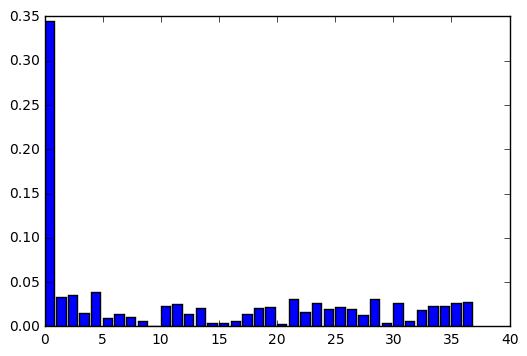

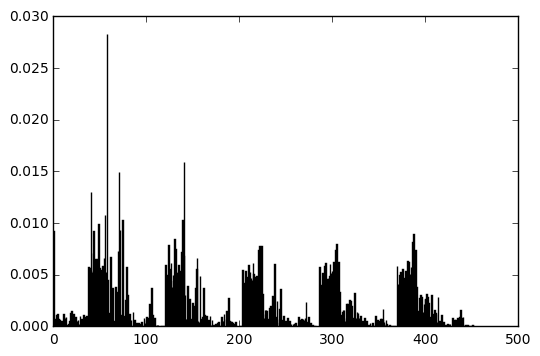

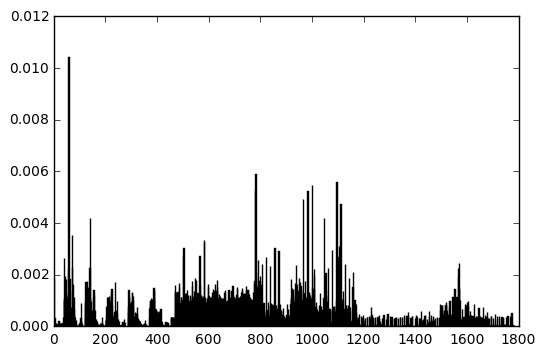

In [68]:
%matplotlib inline
plt.bar(range(len(s_importances_avg)), s_importances_avg)
plt.show()
plt.bar(range(len(s_d_importances_avg)), s_d_importances_avg)
plt.show()
plt.bar(range(len(s_d_t_importances_avg)), s_d_t_importances_avg)
plt.show()

In [25]:
s_importances_sort = s_importances_avg.argsort()[::-1]
s_d_importances_sort = s_d_importances_avg.argsort()[::-1]
s_d_t_importances_sort = s_d_t_importances_avg.argsort()[::-1]

In [145]:
rf_chosen_s = []
rf_chosen_s_d = []
rf_chosen_s_d_t = []
[rf_chosen_s.append(static_names[i]) for i in s_importances_sort]
[rf_chosen_s_d.append(s_d_names[i]) for i in s_d_importances_sort]
[rf_chosen_s_d_t.append(s_d_t_names[i]) for i in s_d_t_importances_sort]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [158]:
dynamic_dict = {
    "51221" : "HEMATOCRIT - BLOOD HEMATOLOGY_",
    '51222' : "HEMOGLOBIN - BLOOD HEMATOLOGY_",
    '51248' : "MCH - BLOOD HEMATOLOGY_",
    '51249' : "MCHC - BLOOD HEMATOLOGY_",
    '51250' : "MCV - BLOOD HEMATOLOGY_",
    '51265' : "PLATELET COUNT - BLOOD HEMATOLOGY_",
    '51277' : "RDW - BLOOD HEMATOLOGY_",
    '51279' : "RED BLOOD CELLS - BLOOD HEMATOLOGY_",
    '51301' : "WHITE BLOOD CELLS - BLOOD HEMATOLOGY_",
    '50868' : "ANION GAP - BLOOD CHEMISTRY_",
    '50882' : "BICARBONATE - BLOOD CHEMISTRY_",
    '50893' : "CALCIUM, TOTAL - BLOOD CHEMISTRY_",
    '50902' : "CHLORIDE - BLOOD CHEMISTRY_",
    '50912' : "CREATININE - BLOOD CHEMISTRY_",
    '50931' : "GLUCOSE - BLOOD CHEMISTRY_",
    '50960' : "MAGNESIUM - BLOOD CHEMISTRY_",
    '50970' : "PHOSPHATE - BLOOD CHEMISTRY_",
    '50971' : "POTASSIUM - BLOOD CHEMISTRY_",
    '50983' : "SODIUM - BLOOD CHEMISTRY_",
    '51006' : "UREA NITROGEN - BLOOD CHEMISTRY_",
    '51' : "Arterial BP [Systolic]_",
    '52' : "Arterial BP Mean_",
    '113' : "CVP_",
    '184' : "Eye Opening_",
    '211' : "Heart Rate_",
    '454' : "Motor Response_",
    '455' : "NBP [Systolic]_",
    '456' : "NBP Mean_",
    '618' : "Respiratory Rate_",
    '646' : "SpO2_",
    '678' : "Temperature F_",
    '679' : "Temperature F (calc)_",
    '723' : "Verbal Response_",
    '5813' : "ABP Alarm [Low]_",
    '5815' : "HR Alarm [Low]_",
    '5817' : "NBP Alarm [Low]_",
    '5819' : "Resp Alarm [Low]_",
    '5820' : "SpO2 Alarm [Low]_",
    '8368' : "Arterial BP [Diastolic]_",
    '8441' : "NBP [Diastolic]_",
    '8547' : "ABP Alarm [High]_",
    '8549' : "HR Alarm [High]_",
    '8551' : "NBP Alarm [High]_",
    '8553' : "Resp Alarm [High]_",
    '8554' : "SpO2 Alarm [High]_",
    '220045' : b"Heart Rate_",
    '220046' : "Heart rate Alarm - High_",
    '220047' : "Heart Rate Alarm - Low_",
    '220050' : "Arterial Blood Pressure systolic_",
    '220051' : "Arterial Blood Pressure diastolic_",
    '220052' : "Arterial Blood Pressure mean_",
    '220056' : "Arterial Blood Pressure Alarm - Low_",
    '220058' : "Arterial Blood Pressure Alarm - High_",
    '220074' : "Central Venous Pressure_",
    '220179' : "Non Invasive Blood Pressure systolic_",
    '220180' : "Non Invasive Blood Pressure diastolic_",
    '220181' : "Non Invasive Blood Pressure mean_",
    '220210' : "Respiratory Rate_",
    '220277' : "O2 saturation pulseoxymetry_",
    '220739' : "GCS - Eye Opening_",
    '223751' : "Non-Invasive Blood Pressure Alarm - High_",
    '223752' : "Non-Invasive Blood Pressure Alarm - Low_",
    '223761' : "Temperature Fahrenheit_",
    '223769' : "O2 Saturation Pulseoxymetry Alarm - High_",
    '223770' : "O2 Saturation Pulseoxymetry Alarm - Low_",
    '223900' : "GCS - Verbal Response_",
    '223901' : "GCS - Motor Response_",
    '224161' :  "Resp Alarm - High_",
    '224162' : "Resp Alarm - Low_"
}
temporal_dict = {
"_1" : "normalized length",
"_2" : "normalized time Of First recording",
"_3" : "normalized time Of Last recording",
"_4" : "avg recording",
"_5" : "std of recordings",
"_6" : "max recording",
"_7" : "min recording",
"_8" : "normalized location of Min",
"_9" : "normalized location of Max",
"_10" : "last recording",
"_11" : "linear avg",
"_12" : "quadratic avg",
"_13" : "absolute differences",
"_14" : "normalized number of increase trend",
"_15" : "normalized number of decrease trend",
"_16" : "fluctuation ratio"
}

def name_converter(feature_names):
    for i in range(len(feature_names)):
        if feature_names[i][-2:] == '_d':
            if feature_names[i][:feature_names[i].index('_')] in dynamic_dict.keys():
                feature_names[i] = str(dynamic_dict[feature_names[i][:feature_names[i].index('_')]]) + str(feature_names[i][feature_names[i].index('_'):])  
        if feature_names[i][-2:] == '_t':
            underscore_positions = [pos for pos, char in enumerate(feature_names[i]) if char == '_']
            if feature_names[i][:feature_names[i].index('_')] in dynamic_dict.keys():
                feature_names[i] = str(dynamic_dict[feature_names[i][:underscore_positions[0]]]) + str(temporal_dict[str(feature_names[i][underscore_positions[0]:underscore_positions[1]])]) + str(feature_names[i][underscore_positions[1]:])  
            #else:
            #    feature_names[i] = feature_names[i][:feature_names[i].index('_')] + str(temporal_dict[str(feature_names[i][underscore_positions[0]:underscore_positions[1]])]) + str(feature_names[i][underscore_positions[1]:])
    return(feature_names)                                                                                               
        

In [162]:
rf_chosen_s_d_t = name_converter(rf_chosen_s_d_t)

In [30]:
print('s min: %s, coef: %f' % (static_names[np.average(coef_mat_s, axis = 0).argmin()], min(np.average(coef_mat_s, axis = 0))))
print('s max: %s, coef: %f' % (static_names[np.average(coef_mat_s, axis = 0).argmax()], max(np.average(coef_mat_s, axis = 0))))
print('s + d min: %s, coef: %f' % (s_d_names[np.average(coef_mat_s_d, axis = 0).argmin()], min(np.average(coef_mat_s_d, axis = 0))))
print('s + d max: %s, coef: %f' % (s_d_names[np.average(coef_mat_s_d, axis = 0).argmax()], max(np.average(coef_mat_s_d, axis = 0))))
print('s + d + t min: %s, coef: %f' % (s_d_t_names[np.average(coef_mat_s_d_t, axis = 0).argmin()], min(np.average(coef_mat_s_d_t, axis = 0))))
print('s + d + t max: %s, coef: %f' % (s_d_t_names[np.average(coef_mat_s_d_t, axis = 0).argmax()], max(np.average(coef_mat_s_d_t, axis = 0))))

s min: admission_type_NEWBORN, coef: -0.544342
s max: cdiff, coef: 0.370834
s + d min: 50960_3, coef: -1.029155
s + d max: YEAST_1, coef: 1.382702
s + d + t min: admission_location_CLINIC REFERRAL/PREMATURE, coef: -0.209545
s + d + t max: 51301_9, coef: 0.378185


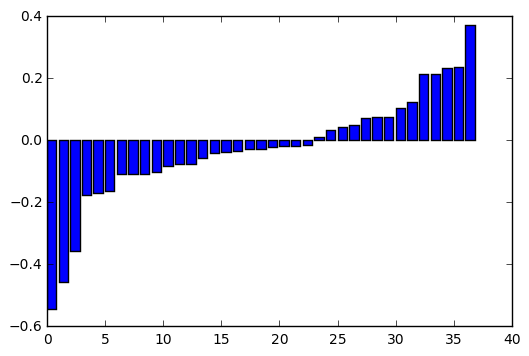

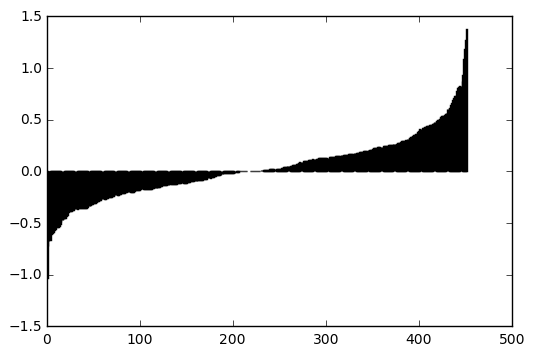

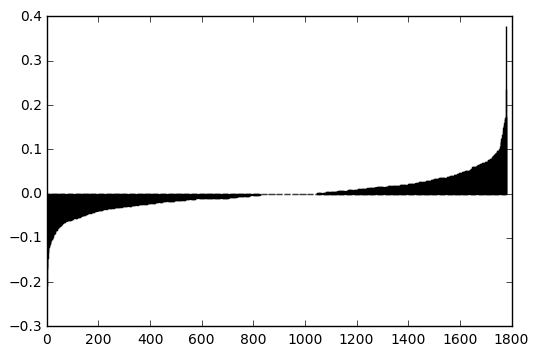

In [25]:
%matplotlib inline

plt.bar(range(static.shape[1]), np.sort(np.average(coef_mat_s, axis = 0)))
plt.show()
plt.bar(range(s_d.shape[1]), np.sort(np.average(coef_mat_s_d, axis = 0)))
plt.show()
plt.bar(range(s_d_t.shape[1]), np.sort(np.average(coef_mat_s_d_t, axis = 0)))
plt.show()

In [163]:
s_sorted_index = list(np.average(coef_mat_s, axis = 0).argsort())
[name_converter(static_names[i]) for i in list(s_sorted_index)]

['admission_type_NEWBORN',
 'admission_location_CLINIC REFERRAL/PREMATURE',
 'insurance_Private',
 'gender_M',
 'ethnicity_OTHER',
 'religion_NOT SPECIFIED',
 'religion_PROTESTANT QUAKER',
 'ethnicity_WHITE',
 'marital_status_MARRIED',
 'gender_F',
 'marital_status_DIVORCED',
 'religion_UNOBTAINABLE',
 'kidney',
 'religion_OTHER',
 'marital_status_SEPARATED',
 'admission_location_PHYS REFERRAL/NORMAL DELI',
 'admission_type_ELECTIVE',
 'admission_location_** INFO NOT AVAILABLE **',
 'marital_status_UNKNOWN (DEFAULT)',
 'insurance_Medicaid',
 'marital_status_SINGLE',
 'insurance_Medicare',
 'admission_location_EMERGENCY ROOM ADMIT',
 'marital_status_WIDOWED',
 'religion_JEWISH',
 'insurance_Self Pay',
 'admission_location_TRANSFER FROM SKILLED NUR',
 'admission_type_URGENT',
 'admission_location_TRANSFER FROM HOSP/EXTRAM',
 'insurance_Government',
 'admission_location_TRANSFER FROM OTHER HEALT',
 'religion_CATHOLIC',
 'admission_type_EMERGENCY',
 'first_admit_age',
 'antib',
 'diab',
 '

In [169]:
s_d_sorted_index = list(np.average(coef_mat_s_d, axis = 0).argsort())
LR_s_d = []
[LR_s_d.append(s_d_names[i]) for i in list(s_d_sorted_index)]
LR_s_d = name_converter(LR_s_d)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [171]:
s_d_t_sorted_index = list(np.average(coef_mat_s_d_t, axis = 0).argsort())# [1700:]
LR_s_d_t = []
[LR_s_d_t.append(s_d_t_names[i]) for i in list(s_d_t_sorted_index)]
LR_s_d_t = name_converter(LR_s_d_t)

In [224]:
coef_mat_s_avg_sorted = np.sort(np.average(coef_mat_s, axis = 0))
coef_mat_s_d_avg_sorted = np.sort(np.average(coef_mat_s_d, axis = 0))
coef_mat_s_d_t_avg_sorted = np.sort(np.average(coef_mat_s_d_t, axis = 0))

In [225]:
a = []
[a.append(static_names[i]) for i in list(np.average(coef_mat_s, axis = 0).argsort())]
a = name_converter(a)
#coef_mat_s_avg_sorted
s_results = pd.DataFrame(columns = ['Feature', 'Coefficient'])
s_results['Feature'] = a
s_results['Coefficient'] = coef_mat_s_avg_sorted

In [226]:
a = []
[a.append(s_d_names[i]) for i in list(np.average(coef_mat_s_d, axis = 0).argsort())]
a = name_converter(a)
s_d_results = pd.DataFrame(columns = ['Feature', 'Coefficient'])
s_d_results['Feature'] = a
s_d_results['Coefficient'] = coef_mat_s_d_avg_sorted

In [229]:
a = []
[a.append(s_d_t_names[i]) for i in list(np.average(coef_mat_s_d_t, axis = 0).argsort())]
a = name_converter(a)
s_d_t_results = pd.DataFrame(columns = ['Feature', 'Coefficient'])
s_d_t_results['Feature'] = a
s_d_t_results['Coefficient'] = coef_mat_s_d_t_avg_sorted

In [234]:
print(s_results)
print(s_d_results)
print(s_d_t_results)

                                         Feature  Coefficient
0                         admission_type_NEWBORN    -0.405064
1   admission_location_CLINIC REFERRAL/PREMATURE    -0.350332
2                              insurance_Private    -0.295343
3                                       gender_M    -0.147046
4                                ethnicity_OTHER    -0.126858
5                         religion_NOT SPECIFIED    -0.126346
6                     religion_PROTESTANT QUAKER    -0.100536
7                                ethnicity_WHITE    -0.100377
8                         marital_status_MARRIED    -0.084554
9                                       gender_F    -0.080189
10                       marital_status_DIVORCED    -0.078370
11                         religion_UNOBTAINABLE    -0.066571
12                                        kidney    -0.055746
13                                religion_OTHER    -0.039327
14                      marital_status_SEPARATED    -0.030499
15  admi

In [64]:
static_pca = PCA().fit(static)
# s_pca = static_pca.transform(static)

s_d = np.concatenate((static, dynamic), axis = 1)
s_d_pca = PCA().fit(s_d)
# s_d_pca = dynamic_pca.transform(s_d)
s_d_t = np.concatenate((static, dynamic, temporal), axis = 1)
s_d_t_pca = PCA().fit(s_d_t)
#s_d_t_pca = temporal_pca.transform(temporal)

In [61]:
s_d_t.shape

(1780, 1389)

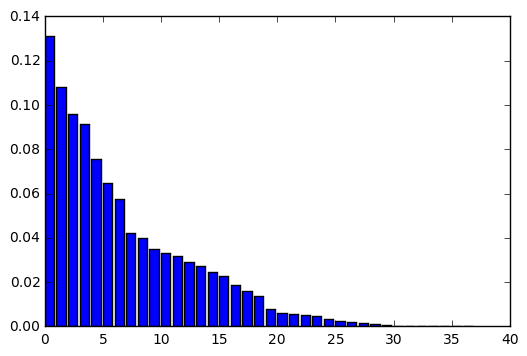

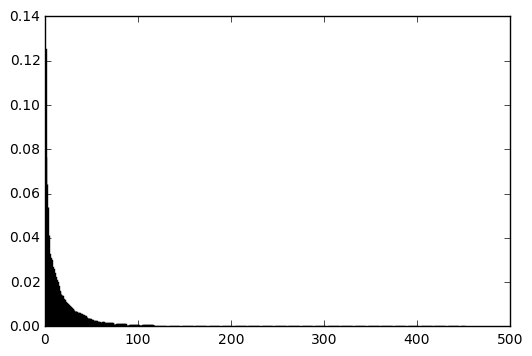

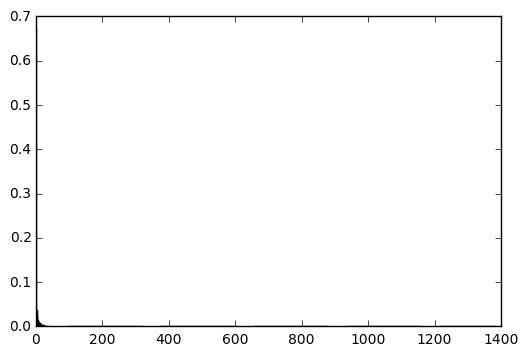

In [62]:
%matplotlib inline
plt.bar(range(static.shape[1]), static_pca.explained_variance_ratio_)
plt.show()
plt.bar(range(s_d.shape[1]), s_d_pca.explained_variance_ratio_)
plt.show()
plt.bar(range(s_d_t.shape[1]), s_d_t_pca.explained_variance_ratio_)
plt.show()

In [63]:
%matplotlib inline
# %matplotlib

np.random.seed(np.random.randint(10000))

# User-set parameters

# Choose which classifier you want to use. Currently supported: 'lin', 'rbf', 'rf'
clf = 'lin'

# Choose feature selection method. Currently supported: 'chi2', 'pca'
featureSelectionMethod = 'chi2'

# Choose whether or not SVM's should include cost sensitive parameters.
costSensitive = False

# Determine if the result should be plotted
plotFlag = False

# Determine which feature sets to combine
requested_feature_set = 'dynamic'

# Number of folds for cross validation
num_folds = 5

# Accessory variables

#percentileList = percentileList[::-1] # reverse the list for accurate time estimations - could cause problems
all_auc_scores = [] # to record the max AUC for the best percentile for each fold
best_auc_positions = [] # to record which percentile is best over the CV folds
fold = 1 # fold counter for print statements
kf = KFold(n_splits = num_folds, shuffle = True) # initialize cross validation
#average_vec = np.array([0] * len(percentileList))
average_vec = []

# chosen_columns = []

# percentile_list = np.arange(100, 105, 5)
percentile_list = [100]
meta_chosen_columns = []  
print('Data: %s \nFeature Selection: %s \nModel type: %s \n'
      % (requested_feature_set, featureSelectionMethod, clf))
## We could loop through feature set combinations as well (code done)
meta_average_vec = []
# for clf in ['lin']: #, 'rbf', 'rf']:
fold = 1
for train, test in kf.split(np.arange(X_train_d.shape[0])):
    for perc in percentile_list:
        average_vec = []
        auc_scores = []
#         print('----- Running fold %i -----' % fold)

        chosen_columns = []

        if requested_feature_set == 'static': # if staticPercentile exists, run feature selection for static features
            CV_X_train_s, CV_X_test_s, CV_y_train_s, CV_y_test_s = X_train_s[train,:], X_train_s[test,:], y_train_s[train], y_train_s[test]

            if featureSelectionMethod == 'pca':
                temp_s = PCA(n_components = 20)
                CV_X_train_s_new = temp_s.fit_transform(CV_X_train_s)
                CV_X_test_s_new = temp_s.transform(CV_X_test_s)
                auc_new = roc_auc_score(CV_y_test_s, 
                                        run_clf(clf, full_features_training, CV_y_train_s,
                                        full_features_testing, costSensitive)[0])
                auc_scores.append(auc_new)
            if featureSelectionMethod == 'chi2':
                for perc in percentile_list:
                    temp_s = SelectPercentile(chi2, percentile = perc)
                    CV_X_train_s_new = temp_s.fit_transform(CV_X_train_s, CV_y_train_s)
                    static_columns = temp_s.get_support(indices=True)
                    CV_X_test_s_new = CV_X_test_s[:,static_columns]
                    chosen_columns.append(static_columns)

                    full_features_training = CV_X_train_s_new
                    full_features_testing = CV_X_test_s_new
                    auc_new = roc_auc_score(CV_y_test_s, 
                                            run_clf(clf, full_features_training, CV_y_train_s,
                                            full_features_testing, costSensitive)[0])
                    auc_scores.append(auc_new)
                    print('Done with perc %i' % perc)

        if requested_feature_set == 'dynamic':
            CV_X_train_d, CV_X_test_d, CV_y_train_d, CV_y_test_d = X_train_d[train,:], X_train_d[test,:], y_train_d[train], y_train_d[test]

            if featureSelectionMethod == 'pca':
                temp_d = PCA(n_components = 3)
                CV_X_train_d_new = temp_d.fit_transform(CV_X_train_d)
                CV_X_test_d_new = temp_d.transform(CV_X_test_d)
                if plotFlag:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection = '3d')
                    ax.scatter(xs = CV_X_train_d_new[:, 0], ys = CV_X_train_d_new[:, 1],
                                   zs = CV_X_train_d_new[:, 2], c = CV_y_train_d)
                    plt.show()
                    fig2 = plt.figure()
                    ax2 = fig2.add_subplot(111, projection = '3d')
                    ax2.scatter(xs = CV_X_test_d_new[:, 0], ys = CV_X_test_d_new[:, 1],
                                   zs = CV_X_test_d_new[:, 2], c = CV_y_test_d)
                    plt.show()
                    for angle in range(0, 360):
                        ax.view_init(30, angle)
                        plt.draw()
                        plt.pause(.0001)
    #                 plt.show()
                    full_features_training = CV_X_train_d_new
                    full_features_testing = CV_X_test_d_new
        #             print('full_features_training: %s' % (full_features_training.shape,))
        #             print('full_features_testing: %s' % (full_features_testing.shape,))
                    auc_new = roc_auc_score(CV_y_test_d, 
                                            run_clf(clf, full_features_training, CV_y_train_d,
                                            full_features_testing, costSensitive)[0])
                    auc_scores.append(auc_new)
                
            if featureSelectionMethod == 'chi2':
                for perc in percentile_list:
                    temp_d = SelectPercentile(chi2, percentile = perc)
                    CV_X_train_d_new = temp_d.fit_transform(CV_X_train_d, CV_y_train_d)
                    dynamic_columns = temp_d.get_support(indices = True)
                    CV_X_test_d_new = CV_X_test_d[:, dynamic_columns]
    #                     dynamic_columns = np.random.randint(low = 0, high = dynamic.shape[1], size = math.ceil(dynamic.shape[1] * 0.2))
                    chosen_columns.append(dynamic_columns)
    #                     CV_X_train_d_new = CV_X_train_d[:, dynamic_columns]
    #                CV_X_test_d_new = CV_X_test_d[:, dynamic_columns]

                    full_features_training = CV_X_train_d_new
                    full_features_testing = CV_X_test_d_new
        #             print('full_features_training: %s' % (full_features_training.shape,))
        #             print('full_features_testing: %s' % (full_features_testing.shape,))
                    auc_new = roc_auc_score(CV_y_test_d, 
                                            run_clf(clf, full_features_training, CV_y_train_d,
                                            full_features_testing, costSensitive)[0])
                    auc_scores.append(auc_new)
#                     print('Done with perc %i' % perc)
        if requested_feature_set == 'temporal':
            CV_X_train_t, CV_X_test_t, CV_y_train_t, CV_y_test_t = X_train_t[train,:], X_train_t[test,:], y_train_t[train], y_train_t[test]

            if featureSelectionMethod == 'pca':
                temp_t = PCA(n_components = 50)
                CV_X_train_t_new = temp_t.fit_transform(CV_X_train_t)
                CV_X_test_t_new = temp_t.transform(CV_X_test_t)
                full_features_training = CV_X_train_t_new
                full_features_testing = CV_X_test_t_new
                auc_new = roc_auc_score(CV_y_test_t, 
                                        run_clf(clf, full_features_training, CV_y_train_t,
                                        full_features_testing, costSensitive)[0])
                auc_scores.append(auc_new)

                if plotFlag:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection = '3d')
                    ax.scatter(xs = CV_X_train_t_new[:, 0], ys = CV_X_train_t_new[:, 1],
                                   zs = CV_X_train_t_new[:, 2], c = CV_y_train_t)
                    plt.show()
                    fig2 = plt.figure()
                    ax2 = fig2.add_subplot(111, projection = '3d')
                    ax2.scatter(xs = CV_X_test_t_new[:, 0], ys = CV_X_test_t_new[:, 1],
                                   zs = CV_X_test_t_new[:, 2], c = CV_y_test_t)
                    plt.show()

            if featureSelectionMethod == 'chi2':
                for perc in percentileList:
                    temp_t = SelectPercentile(chi2, percentile = perc)
                    CV_X_train_t_new = temp_t.fit_transform(CV_X_train_t, CV_y_train_t)    
                    temporal_columns = temp_t.get_support(indices=True)
                    CV_X_test_t_new = CV_X_test_t[:,temporal_columns]
                    chosen_columns.append(temporal_columns)

                    full_features_training = CV_X_train_t_new
                    full_features_testing = CV_X_test_t_new
                    auc_new = roc_auc_score(CV_y_test_t, 
                                            run_clf(clf, full_features_training, CV_y_train_t,
                                            full_features_testing, costSensitive)[0])
                    auc_scores.append(auc_new)
                    print('Done with perc %i' % perc)
        average_vec.append(auc_scores)
        print('--------------------\nDone with fold %i\n---------------' % fold)
        fold += 1
#         print('----- Run complete for fold %i -----\n' % fold)
    meta_average_vec.append(np.mean(average_vec, axis = 0))
    meta_chosen_columns.append(chosen_columns)
    #print('Max AUC is', max(auc_scores), 'with %i percent of the features used.' % best_percentile)
    #all_auc_scores.append(max(auc_scores))
    #best_auc_positions.append(percentileList[np.array(auc_scores).argmax()])
meta_average_vec = np.array(meta_average_vec)
# print('AUC per fold:', meta_average_vec)
print('Average AUC across all folds: ', np.mean(meta_average_vec, axis = 1))
print('Done!')     

1389